In [1]:
import numpy as np
import scipy
import sys
import os
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from lspin_model import Model
from utils import DataSet

from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import cm,colors

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Linear synthetic data generation

Group 1: $X$ ~ $N(1,0.5)$,  $Y = -2X_1 + X_2 - 0.5X_3$

Group 2: $X$ ~ $N(-1,0.5)$, $Y = -0.5X_3 + X_4 - 2X_5$



In [3]:
np.random.seed(34)

Xs1 = np.random.normal(loc=1,scale=0.5,size=(300,5))
Ys1 = -2*Xs1[:,0]+1*Xs1[:,1]-0.5*Xs1[:,2]

Xs2 = np.random.normal(loc=-1,scale=0.5,size=(300,5))
Ys2 = -0.5*Xs2[:,2]+1*Xs2[:,3]-2*Xs2[:,4]

In [4]:
X_data = np.concatenate((Xs1,Xs2),axis=0)
Y_data = np.concatenate((Ys1.reshape(-1,1),Ys2.reshape(-1,1)),axis=0)

In [5]:
Y_data = Y_data-Y_data.min()
Y_data=Y_data/Y_data.max()

In [6]:
# The ground truth group label of each sample
case_labels = np.concatenate((np.array([1]*300),np.array([2]*300)))

In [7]:
Y_data = np.concatenate((Y_data,case_labels.reshape(-1,1)),axis=1)

In [8]:
# 10% for validation, 10% for test 
X_train,X_remain,yc_train,yc_remain = train_test_split(X_data,Y_data,train_size=0.8,shuffle=True,random_state=34)
X_valid,X_test,yc_valid,yc_test = train_test_split(X_remain,yc_remain,train_size=0.5,shuffle=True,random_state=34)

In [9]:
# Only 10 samples used for training
X_train,_,yc_train,_ = train_test_split(X_train,yc_train,train_size=10,shuffle=True,random_state=34)

In [10]:
print("Sample sizes:")
print(X_train.shape[0],X_valid.shape[0],X_test.shape[0])

Sample sizes:
10 60 60


In [11]:
y_train = yc_train[:,0].reshape(-1,1)
y_valid = yc_valid[:,0].reshape(-1,1)
y_test = yc_test[:,0].reshape(-1,1)

In [12]:
train_label = yc_train[:,1]
valid_label = yc_valid[:,1]
test_label= yc_test[:,1]

In [13]:
Counter(train_label)

Counter({2.0: 6, 1.0: 4})

In [14]:
Counter(valid_label)

Counter({2.0: 29, 1.0: 31})

In [15]:
dataset = DataSet(**{'_data':X_train, '_labels':y_train,
                '_valid_data':X_valid, '_valid_labels':y_valid,
                '_test_data':X_test, '_test_labels':y_test})

In [16]:
# reference ground truth feature matrix (training/test)
ref_feat_mat_train = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in train_label])
ref_feat_mat_test = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in test_label])

### LLSPIN

In [17]:
# objective function for optuna hyper-parameter optimization
def llspin_objective(trial):  
    global model
    
    # hyper-parameter specification
    params = {     
        "input_node" : X_train.shape[1], # input dimension for the prediction network
        "hidden_layers_node" : [100,100,10,1], # number of nodes for each hidden layer of the prediction net
        "output_node" : 1, # number of nodes for the output layer of the prediction net
        "feature_selection" : True, # if using the gating net
        "gating_net_hidden_layers_node": [10], # number of nodes for each hidden layer of the gating net
        "display_step" : 500 # number of epochs to output info
    }
    params['activation']= 'none' # linear prediction
    params['batch_size']= X_train.shape[0]
    
    # hyper-parameter to optimize: lambda, learning rate, number of epochs
    params['lam'] = trial.suggest_loguniform('lam',1e-3,1e-2)
    params['learning_rate'] = trial.suggest_loguniform('learning_rate', 1e-2, 2e-1)
    num_epoch = trial.suggest_categorical('num_epoch', [2000,5000,10000,15000])

    # specify the model with these parameters and train the model
    model_dir =None
    model = Model(**params)
    train_acces, train_losses, val_acces, val_losses = model.train(trial, dataset, model_dir, num_epoch=num_epoch)

    print("In trial:---------------------")
    val_prediction = model.test(X_valid)[0]
    mse = mean_squared_error(y_valid.reshape(-1),val_prediction.reshape(-1))
    print("validation mse: {}".format(mse))
    
    loss= mse
            
    return loss
        
def callback(study,trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

In [18]:
# optimize the model via Optuna and obtain the best model with smallest validation mse
best_model = None
model = None
study = optuna.create_study(pruner=None)
study.optimize(llspin_objective, n_trials=100, callbacks=[callback])

[I 2021-06-09 00:52:31,328] A new study created in memory with name: no-name-c0d16df7-44bc-4384-8cd6-d10d3b72ff74








Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



num_samples : 10
Epoch: 500 train loss=0.017599225 valid loss= 0.009803707
train reg_fs: 0.0026826176326721907
Epoch: 1000 train loss=0.010520567 valid loss= 0.009543489
train reg_fs: 0.002700003096833825
Epoch: 1500 train loss=0.009960390 valid loss= 0.008896006
train reg_fs: 0.0026686268392950296
Epoch: 2000 train loss=0.012702882 valid loss= 0.007787749
train reg_fs: 0.0026157291140407324
Epoch: 2500 train loss=0.008682169 valid loss= 0.006479782
train reg_fs: 0.002568244468420744
Epoch: 3000 train loss=0.011089993 valid loss= 0.005771696
train reg_fs: 0.0025229600723832846
Epoch: 3500 

[I 2021-06-09 00:53:06,933] Trial 0 finished with value: 0.0019158950122663443 and parameters: {'lam': 0.003109097570843857, 'learning_rate': 0.05286484324645007, 'num_epoch': 5000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 5000 train loss=0.003308428 valid loss= 0.004289762
train reg_fs: 0.0023707805667072535
Optimization Finished!
test loss: 0.004358295351266861, test acc: 1.0
In trial:---------------------
validation mse: 0.0019158950122663443
num_samples : 10
Epoch: 500 train loss=0.012889587 valid loss= 0.009258475
train reg_fs: 0.0028443753253668547
Epoch: 1000 train loss=0.016264895 valid loss= 0.008787489
train reg_fs: 0.0028587719425559044
Epoch: 1500 train loss=0.009756874 valid loss= 0.008535736
train reg_fs: 0.002857065526768565


[I 2021-06-09 00:53:21,028] Trial 1 finished with value: 0.004561767628598593 and parameters: {'lam': 0.003367740952527124, 'learning_rate': 0.025243603169729154, 'num_epoch': 2000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 2000 train loss=0.004154135 valid loss= 0.007435099
train reg_fs: 0.0028377363923937082
Optimization Finished!
test loss: 0.008847445249557495, test acc: 1.0
In trial:---------------------
validation mse: 0.004561767628598593
num_samples : 10
Epoch: 500 train loss=0.007135219 valid loss= 0.009976786
train reg_fs: 0.003720809007063508
Epoch: 1000 train loss=0.009201998 valid loss= 0.007740718
train reg_fs: 0.0036040020640939474
Epoch: 1500 train loss=0.008841582 valid loss= 0.006245501
train reg_fs: 0.0035132193006575108
Epoch: 2000 train loss=0.007754317 valid loss= 0.005703736
train reg_fs: 0.0033892765641212463
Epoch: 2500 train loss=0.005383029 valid loss= 0.005936324
train reg_fs: 0.0033251733984798193
Epoch: 3000 train loss=0.010597482 valid loss= 0.006071387
train reg_fs: 0.003254116978496313
Epoch: 3500 train loss=0.004761461 valid loss= 0.005705884
train reg_fs: 0.0031844887416809797
Epoch: 4000 train loss=0.003374434 valid loss= 0.005637813
train reg_fs: 0.0031311283819

[I 2021-06-09 00:53:54,262] Trial 2 finished with value: 0.0024211690894986914 and parameters: {'lam': 0.0043535096845443, 'learning_rate': 0.14484863377484125, 'num_epoch': 5000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 5000 train loss=0.008109301 valid loss= 0.005396350
train reg_fs: 0.0030480637215077877
Optimization Finished!
test loss: 0.005291616544127464, test acc: 1.0
In trial:---------------------
validation mse: 0.0024211690894986914
num_samples : 10
Epoch: 500 train loss=0.011965651 valid loss= 0.014838692
train reg_fs: 0.007900225929915905
Epoch: 1000 train loss=0.018202525 valid loss= 0.015104955
train reg_fs: 0.007969016209244728
Epoch: 1500 train loss=0.032854479 valid loss= 0.014160577
train reg_fs: 0.008026977069675922
Epoch: 2000 train loss=0.017814379 valid loss= 0.014403672
train reg_fs: 0.008067387156188488
Epoch: 2500 train loss=0.026844837 valid loss= 0.014861772
train reg_fs: 0.00809737853705883
Epoch: 3000 train loss=0.022846783 valid loss= 0.014084207
train reg_fs: 0.008111383765935898
Epoch: 3500 train loss=0.018160027 valid loss= 0.014304592
train reg_fs: 0.008116794750094414
Epoch: 4000 train loss=0.011439086 valid loss= 0.013635501
train reg_fs: 0.008116059936583042

[I 2021-06-09 00:55:29,371] Trial 3 finished with value: 0.0025383778103019185 and parameters: {'lam': 0.009312558203049909, 'learning_rate': 0.020541325985025255, 'num_epoch': 15000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 15000 train loss=0.015242752 valid loss= 0.009681478
train reg_fs: 0.007128414232283831
Optimization Finished!
test loss: 0.010543831624090672, test acc: 1.0
In trial:---------------------
validation mse: 0.0025383778103019185
num_samples : 10
Epoch: 500 train loss=0.013283363 valid loss= 0.007500133
train reg_fs: 0.0010628411546349525
Epoch: 1000 train loss=0.008317947 valid loss= 0.008411075
train reg_fs: 0.0010776271810755134
Epoch: 1500 train loss=0.008841781 valid loss= 0.008901252
train reg_fs: 0.0010716910474002361


[I 2021-06-09 00:55:43,895] Trial 4 finished with value: 0.006346167462504215 and parameters: {'lam': 0.001205503174440379, 'learning_rate': 0.07899067917668938, 'num_epoch': 2000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 2000 train loss=0.005188718 valid loss= 0.007394572
train reg_fs: 0.001042633200995624
Optimization Finished!
test loss: 0.006801971700042486, test acc: 1.0
In trial:---------------------
validation mse: 0.006346167462504215
num_samples : 10
Epoch: 500 train loss=0.024429297 valid loss= 0.009794060
train reg_fs: 0.0025349354837089777
Epoch: 1000 train loss=0.024867056 valid loss= 0.009684325
train reg_fs: 0.0025522171054035425
Epoch: 1500 train loss=0.011374202 valid loss= 0.009088317
train reg_fs: 0.0025681264232844114
Epoch: 2000 train loss=0.019218370 valid loss= 0.009173948
train reg_fs: 0.0025839509908109903
Epoch: 2500 train loss=0.009424584 valid loss= 0.009139762
train reg_fs: 0.0025966118555516005
Epoch: 3000 train loss=0.005359564 valid loss= 0.009023453
train reg_fs: 0.002607989124953747
Epoch: 3500 train loss=0.009212853 valid loss= 0.008783948
train reg_fs: 0.0026179752312600613
Epoch: 4000 train loss=0.013858124 valid loss= 0.008922284
train reg_fs: 0.0026270688977

[I 2021-06-09 00:56:17,063] Trial 5 finished with value: 0.005910998167392975 and parameters: {'lam': 0.0029984587342626037, 'learning_rate': 0.010883204429144425, 'num_epoch': 5000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 5000 train loss=0.008263897 valid loss= 0.008559898
train reg_fs: 0.0026425854302942753
Optimization Finished!
test loss: 0.010762413032352924, test acc: 1.0
In trial:---------------------
validation mse: 0.005910998167392975
num_samples : 10
Epoch: 500 train loss=0.012410039 valid loss= 0.008778282
train reg_fs: 0.0009468196658417583
Epoch: 1000 train loss=0.007258332 valid loss= 0.008665619
train reg_fs: 0.0009555765427649021
Epoch: 1500 train loss=0.011216204 valid loss= 0.008852862
train reg_fs: 0.0009632044821046293


[I 2021-06-09 00:56:31,635] Trial 6 finished with value: 0.006970799637919895 and parameters: {'lam': 0.0011122005355515263, 'learning_rate': 0.014432418717556031, 'num_epoch': 2000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 2000 train loss=0.008551621 valid loss= 0.007939178
train reg_fs: 0.0009696453344076872
Optimization Finished!
test loss: 0.011084811761975288, test acc: 1.0
In trial:---------------------
validation mse: 0.006970799637919895
num_samples : 10
Epoch: 500 train loss=0.017673464 valid loss= 0.015181055
train reg_fs: 0.007364535704255104
Epoch: 1000 train loss=0.021291077 valid loss= 0.014806105
train reg_fs: 0.007386370096355677
Epoch: 1500 train loss=0.010342569 valid loss= 0.014002466
train reg_fs: 0.007163741625845432


[I 2021-06-09 00:56:45,724] Trial 7 finished with value: 0.005209892744125329 and parameters: {'lam': 0.008521367651482722, 'learning_rate': 0.07005203928069247, 'num_epoch': 2000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 2000 train loss=0.018440813 valid loss= 0.012271039
train reg_fs: 0.0068618482910096645
Optimization Finished!
test loss: 0.013783765956759453, test acc: 1.0
In trial:---------------------
validation mse: 0.005209892744125329
num_samples : 10
Epoch: 500 train loss=0.015865270 valid loss= 0.009908026
train reg_fs: 0.001943036331795156
Epoch: 1000 train loss=0.013593690 valid loss= 0.009349792
train reg_fs: 0.001962430542334914
Epoch: 1500 train loss=0.004657848 valid loss= 0.010093950
train reg_fs: 0.0019556363113224506
Epoch: 2000 train loss=0.016899124 valid loss= 0.009642023
train reg_fs: 0.0019309051567688584
Epoch: 2500 train loss=0.004161506 valid loss= 0.009113250
train reg_fs: 0.0018943569157272577
Epoch: 3000 train loss=0.010489115 valid loss= 0.008614630
train reg_fs: 0.0018581796903163195
Epoch: 3500 train loss=0.006717956 valid loss= 0.008067733
train reg_fs: 0.0018308523576706648
Epoch: 4000 train loss=0.007813803 valid loss= 0.007808443
train reg_fs: 0.0018061280716

[I 2021-06-09 00:57:49,919] Trial 8 finished with value: 0.0031656520449314845 and parameters: {'lam': 0.002275109902953339, 'learning_rate': 0.043489048045279095, 'num_epoch': 10000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 10000 train loss=0.003846522 valid loss= 0.004699869
train reg_fs: 0.0015221349895000458
Optimization Finished!
test loss: 0.004752472974359989, test acc: 1.0
In trial:---------------------
validation mse: 0.0031656520449314845
num_samples : 10
Epoch: 500 train loss=0.017438743 valid loss= 0.011763918
train reg_fs: 0.004780938383191824
Epoch: 1000 train loss=0.023087438 valid loss= 0.011925256
train reg_fs: 0.004839390050619841
Epoch: 1500 train loss=0.011132429 valid loss= 0.010694960
train reg_fs: 0.004865658935159445
Epoch: 2000 train loss=0.012049356 valid loss= 0.010579817
train reg_fs: 0.004870280623435974
Epoch: 2500 train loss=0.015440311 valid loss= 0.010339355
train reg_fs: 0.004849697928875685
Epoch: 3000 train loss=0.006189169 valid loss= 0.010435097
train reg_fs: 0.004804507363587618
Epoch: 3500 train loss=0.008854603 valid loss= 0.010430496
train reg_fs: 0.0047462452203035355
Epoch: 4000 train loss=0.011289106 valid loss= 0.009532496
train reg_fs: 0.004681705962866

[I 2021-06-09 00:58:23,301] Trial 9 finished with value: 0.0035977176458469175 and parameters: {'lam': 0.0056042685673374365, 'learning_rate': 0.026561797184474604, 'num_epoch': 5000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 5000 train loss=0.007916812 valid loss= 0.008185596
train reg_fs: 0.0045423139818012714
Optimization Finished!
test loss: 0.00922396406531334, test acc: 1.0
In trial:---------------------
validation mse: 0.0035977176458469175
num_samples : 10
Epoch: 500 train loss=0.015086934 valid loss= 0.005379672
train reg_fs: 0.0015042346203699708
Epoch: 1000 train loss=0.003748092 valid loss= 0.003759054
train reg_fs: 0.0014303105417639017
Epoch: 1500 train loss=0.004444505 valid loss= 0.003939445
train reg_fs: 0.0014201896265149117
Epoch: 2000 train loss=0.004114608 valid loss= 0.004243724
train reg_fs: 0.0014217934804037213
Epoch: 2500 train loss=0.004244187 valid loss= 0.004437586
train reg_fs: 0.0014090214390307665
Epoch: 3000 train loss=0.009959837 valid loss= 0.003803302
train reg_fs: 0.00138817448168993
Epoch: 3500 train loss=0.006269462 valid loss= 0.003955007
train reg_fs: 0.0013705934397876263
Epoch: 4000 train loss=0.005642560 valid loss= 0.003465519
train reg_fs: 0.0013591257156

[I 2021-06-09 00:58:56,575] Trial 10 finished with value: 0.002055121216692203 and parameters: {'lam': 0.0018260342267226027, 'learning_rate': 0.16902384848075502, 'num_epoch': 5000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 5000 train loss=0.002632040 valid loss= 0.003372899
train reg_fs: 0.0013431836850941181
Optimization Finished!
test loss: 0.0032872636802494526, test acc: 1.0
In trial:---------------------
validation mse: 0.002055121216692203
num_samples : 10
Epoch: 500 train loss=0.009543888 valid loss= 0.007493842
train reg_fs: 0.0016573983011767268
Epoch: 1000 train loss=0.007309724 valid loss= 0.008589989
train reg_fs: 0.0016069612465798855
Epoch: 1500 train loss=0.001986773 valid loss= 0.006204158
train reg_fs: 0.0015716799534857273
Epoch: 2000 train loss=0.006217625 valid loss= 0.006172692
train reg_fs: 0.0015443670563399792
Epoch: 2500 train loss=0.002703015 valid loss= 0.004777848
train reg_fs: 0.0015223704976961017
Epoch: 3000 train loss=0.006969748 valid loss= 0.005174747
train reg_fs: 0.001511340495198965
Epoch: 3500 train loss=0.004062497 valid loss= 0.004497785
train reg_fs: 0.0014888389268890023
Epoch: 4000 train loss=0.004996014 valid loss= 0.004715838
train reg_fs: 0.00147055857

[I 2021-06-09 00:59:29,614] Trial 11 finished with value: 0.003774746111684997 and parameters: {'lam': 0.0018578759280840596, 'learning_rate': 0.19966681191322835, 'num_epoch': 5000}. Best is trial 0 with value: 0.0019158950122663443.


Epoch: 5000 train loss=0.002913945 valid loss= 0.005218673
train reg_fs: 0.0014362243236973882
Optimization Finished!
test loss: 0.005533806048333645, test acc: 1.0
In trial:---------------------
validation mse: 0.003774746111684997
num_samples : 10
Epoch: 500 train loss=0.011037333 valid loss= 0.007493242
train reg_fs: 0.0014820626238361
Epoch: 1000 train loss=0.002921403 valid loss= 0.004839448
train reg_fs: 0.0014411400770768523
Epoch: 1500 train loss=0.004636136 valid loss= 0.003692130
train reg_fs: 0.0013896638993173838
Epoch: 2000 train loss=0.011354254 valid loss= 0.002959085
train reg_fs: 0.001342245377600193
Epoch: 2500 train loss=0.002818305 valid loss= 0.002844139
train reg_fs: 0.001316593959927559
Epoch: 3000 train loss=0.002272474 valid loss= 0.003506027
train reg_fs: 0.001300967182032764
Epoch: 3500 train loss=0.006249971 valid loss= 0.002816228
train reg_fs: 0.0012915028491988778
Epoch: 4000 train loss=0.002898016 valid loss= 0.002940176
train reg_fs: 0.00128493283409625

[I 2021-06-09 01:00:02,636] Trial 12 finished with value: 0.0016000980845139274 and parameters: {'lam': 0.001707548866075967, 'learning_rate': 0.11351164552423795, 'num_epoch': 5000}. Best is trial 12 with value: 0.0016000980845139274.


Epoch: 5000 train loss=0.002250574 valid loss= 0.002857555
train reg_fs: 0.001277283183299005
Optimization Finished!
test loss: 0.002842481480911374, test acc: 1.0
In trial:---------------------
validation mse: 0.0016000980845139274
num_samples : 10
Epoch: 500 train loss=0.012104578 valid loss= 0.006016007
train reg_fs: 0.0012891606893390417
Epoch: 1000 train loss=0.004953785 valid loss= 0.004769636
train reg_fs: 0.0012667024275287986
Epoch: 1500 train loss=0.013119777 valid loss= 0.003381038
train reg_fs: 0.0012119775637984276
Epoch: 2000 train loss=0.008891872 valid loss= 0.003104173
train reg_fs: 0.0011755652958527207
Epoch: 2500 train loss=0.005641773 valid loss= 0.003161077
train reg_fs: 0.0011552789947018027
Epoch: 3000 train loss=0.006440981 valid loss= 0.003428821
train reg_fs: 0.0011412908788770437
Epoch: 3500 train loss=0.006324870 valid loss= 0.003089080
train reg_fs: 0.0011297540040686727
Epoch: 4000 train loss=0.003936912 valid loss= 0.003105747
train reg_fs: 0.00112116627

[I 2021-06-09 01:00:35,955] Trial 13 finished with value: 0.001979254790884879 and parameters: {'lam': 0.0014802313374753268, 'learning_rate': 0.09198560066650034, 'num_epoch': 5000}. Best is trial 12 with value: 0.0016000980845139274.


Epoch: 5000 train loss=0.003946026 valid loss= 0.003077067
train reg_fs: 0.0011119329137727618
Optimization Finished!
test loss: 0.0029875347390770912, test acc: 1.0
In trial:---------------------
validation mse: 0.001979254790884879
num_samples : 10
Epoch: 500 train loss=0.014741691 valid loss= 0.009670508
train reg_fs: 0.002102744299918413
Epoch: 1000 train loss=0.009555127 valid loss= 0.007870799
train reg_fs: 0.002116461982950568
Epoch: 1500 train loss=0.013046194 valid loss= 0.006990056
train reg_fs: 0.002106437226757407
Epoch: 2000 train loss=0.005440332 valid loss= 0.007101049
train reg_fs: 0.0020660990849137306
Epoch: 2500 train loss=0.013984112 valid loss= 0.006151279
train reg_fs: 0.002016667043790221
Epoch: 3000 train loss=0.004072323 valid loss= 0.004277388
train reg_fs: 0.001966223120689392
Epoch: 3500 train loss=0.006158381 valid loss= 0.004338600
train reg_fs: 0.0019197763176634908
Epoch: 4000 train loss=0.009862266 valid loss= 0.004003931
train reg_fs: 0.001872488530352

[I 2021-06-09 01:01:40,830] Trial 14 finished with value: 0.001188616769500771 and parameters: {'lam': 0.002464837388285686, 'learning_rate': 0.04429557518945829, 'num_epoch': 10000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 10000 train loss=0.003954059 valid loss= 0.002931652
train reg_fs: 0.0016433803830295801
Optimization Finished!
test loss: 0.003651766572147608, test acc: 1.0
In trial:---------------------
validation mse: 0.001188616769500771
num_samples : 10
Epoch: 500 train loss=0.010518822 valid loss= 0.009154238
train reg_fs: 0.001951304031535983
Epoch: 1000 train loss=0.024430819 valid loss= 0.009559793
train reg_fs: 0.0019772632513195276
Epoch: 1500 train loss=0.009988625 valid loss= 0.008127637
train reg_fs: 0.00197817524895072
Epoch: 2000 train loss=0.005767078 valid loss= 0.007694330
train reg_fs: 0.001962018432095647
Epoch: 2500 train loss=0.007328004 valid loss= 0.006818852
train reg_fs: 0.001938093570061028
Epoch: 3000 train loss=0.009155928 valid loss= 0.006174891
train reg_fs: 0.0019217540975660086
Epoch: 3500 train loss=0.016287832 valid loss= 0.005801133
train reg_fs: 0.0019073091680184007
Epoch: 4000 train loss=0.006070209 valid loss= 0.005365288
train reg_fs: 0.001897079637274

[I 2021-06-09 01:02:45,738] Trial 15 finished with value: 0.002701767685284526 and parameters: {'lam': 0.0022818836707581237, 'learning_rate': 0.04446453313084925, 'num_epoch': 10000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 10000 train loss=0.003872179 valid loss= 0.004505359
train reg_fs: 0.0017930682515725493
Optimization Finished!
test loss: 0.004568408243358135, test acc: 1.0
In trial:---------------------
validation mse: 0.002701767685284526
num_samples : 10
Epoch: 500 train loss=0.020088818 valid loss= 0.007026346
train reg_fs: 0.001217343844473362
Epoch: 1000 train loss=0.004650804 valid loss= 0.006717105
train reg_fs: 0.001144515466876328
Epoch: 1500 train loss=0.002822463 valid loss= 0.003983107
train reg_fs: 0.001057192450389266
Epoch: 2000 train loss=0.002389638 valid loss= 0.004755068
train reg_fs: 0.0009985847864300013
Epoch: 2500 train loss=0.003346324 valid loss= 0.004020947
train reg_fs: 0.0009624623926356435
Epoch: 3000 train loss=0.001999911 valid loss= 0.003632803
train reg_fs: 0.000936285883653909
Epoch: 3500 train loss=0.001560811 valid loss= 0.003776175
train reg_fs: 0.0009173640282824636
Epoch: 4000 train loss=0.001816836 valid loss= 0.003531075
train reg_fs: 0.00090338417794

[I 2021-06-09 01:03:50,627] Trial 16 finished with value: 0.0022182427071780076 and parameters: {'lam': 0.0013951877574811366, 'learning_rate': 0.12257368779204471, 'num_epoch': 10000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 10000 train loss=0.003078718 valid loss= 0.003056957
train reg_fs: 0.0008546410244889557
Optimization Finished!
test loss: 0.002862113295122981, test acc: 1.0
In trial:---------------------
validation mse: 0.0022182427071780076
num_samples : 10
Epoch: 500 train loss=0.011670704 valid loss= 0.007587658
train reg_fs: 0.0008669969392940402
Epoch: 1000 train loss=0.008049794 valid loss= 0.007444090
train reg_fs: 0.0008810067665763199
Epoch: 1500 train loss=0.016474508 valid loss= 0.006808816
train reg_fs: 0.0008896002545952797
Epoch: 2000 train loss=0.014185769 valid loss= 0.005801558
train reg_fs: 0.0008953736396506429
Epoch: 2500 train loss=0.007082607 valid loss= 0.007004485
train reg_fs: 0.000898435537237674
Epoch: 3000 train loss=0.011929817 valid loss= 0.006501300
train reg_fs: 0.0008983365842141211
Epoch: 3500 train loss=0.005223769 valid loss= 0.006117079
train reg_fs: 0.0008960498380474746
Epoch: 4000 train loss=0.009080629 valid loss= 0.006802148
train reg_fs: 0.0008926842

[I 2021-06-09 01:05:27,716] Trial 17 finished with value: 0.002566502383880257 and parameters: {'lam': 0.0010076879198030891, 'learning_rate': 0.031132229400378755, 'num_epoch': 15000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 15000 train loss=0.004122237 valid loss= 0.003387248
train reg_fs: 0.0008134509553201497
Optimization Finished!
test loss: 0.003918431233614683, test acc: 1.0
In trial:---------------------
validation mse: 0.002566502383880257
num_samples : 10
Epoch: 500 train loss=0.010787385 valid loss= 0.008186467
train reg_fs: 0.0019401428289711475
Epoch: 1000 train loss=0.015794309 valid loss= 0.006929010
train reg_fs: 0.0018930177902802825
Epoch: 1500 train loss=0.012634207 valid loss= 0.005365950
train reg_fs: 0.0018256899202242494
Epoch: 2000 train loss=0.006275036 valid loss= 0.004434763
train reg_fs: 0.001774087082594633
Epoch: 2500 train loss=0.003281775 valid loss= 0.004417534
train reg_fs: 0.0017460375092923641
Epoch: 3000 train loss=0.007888897 valid loss= 0.004384822
train reg_fs: 0.0017322369385510683
Epoch: 3500 train loss=0.005827102 valid loss= 0.004694010
train reg_fs: 0.001722276909276843
Epoch: 4000 train loss=0.008573215 valid loss= 0.004599012
train reg_fs: 0.001717009814

[I 2021-06-09 01:06:32,952] Trial 18 finished with value: 0.0024569099587906126 and parameters: {'lam': 0.002301697951926393, 'learning_rate': 0.062031913843521795, 'num_epoch': 10000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 10000 train loss=0.005467426 valid loss= 0.004014633
train reg_fs: 0.0015484013129025698
Optimization Finished!
test loss: 0.0037192674353718758, test acc: 1.0
In trial:---------------------
validation mse: 0.0024569099587906126
num_samples : 10
Epoch: 500 train loss=0.012038191 valid loss= 0.008896755
train reg_fs: 0.0036167148500680923
Epoch: 1000 train loss=0.015283912 valid loss= 0.007943163
train reg_fs: 0.0034172905143350363
Epoch: 1500 train loss=0.010002229 valid loss= 0.006381122
train reg_fs: 0.0032150419428944588
Epoch: 2000 train loss=0.009548806 valid loss= 0.006203355
train reg_fs: 0.003110178979113698
Epoch: 2500 train loss=0.014128167 valid loss= 0.006575461
train reg_fs: 0.003030070336535573
Epoch: 3000 train loss=0.005462516 valid loss= 0.006412106
train reg_fs: 0.002939297817647457
Epoch: 3500 train loss=0.005496585 valid loss= 0.006430835
train reg_fs: 0.002835890045389533
Epoch: 4000 train loss=0.003467415 valid loss= 0.005631566
train reg_fs: 0.002751959720

[I 2021-06-09 01:07:37,972] Trial 19 finished with value: 0.0023291598956897987 and parameters: {'lam': 0.0041665364940078374, 'learning_rate': 0.11208180875480553, 'num_epoch': 10000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 10000 train loss=0.002915422 valid loss= 0.004811608
train reg_fs: 0.0025381334125995636
Optimization Finished!
test loss: 0.004634168930351734, test acc: 1.0
In trial:---------------------
validation mse: 0.0023291598956897987
num_samples : 10
Epoch: 500 train loss=0.018471058 valid loss= 0.008864789
train reg_fs: 0.0014895915519446135
Epoch: 1000 train loss=0.026374064 valid loss= 0.009379271
train reg_fs: 0.0015189958503469825
Epoch: 1500 train loss=0.017305741 valid loss= 0.008649908
train reg_fs: 0.001534992246888578
Epoch: 2000 train loss=0.005902180 valid loss= 0.008814957
train reg_fs: 0.0015438144328072667
Epoch: 2500 train loss=0.006193914 valid loss= 0.008685604
train reg_fs: 0.0015465228352695704
Epoch: 3000 train loss=0.009687342 valid loss= 0.007850058
train reg_fs: 0.0015419303672388196
Epoch: 3500 train loss=0.003745610 valid loss= 0.007684909
train reg_fs: 0.0015336923534050584
Epoch: 4000 train loss=0.006245969 valid loss= 0.007611916
train reg_fs: 0.0015194551

[I 2021-06-09 01:09:14,817] Trial 20 finished with value: 0.0029080466119087334 and parameters: {'lam': 0.001724656415541211, 'learning_rate': 0.038520380144413016, 'num_epoch': 15000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 15000 train loss=0.005901225 valid loss= 0.004195197
train reg_fs: 0.0013033243594691157
Optimization Finished!
test loss: 0.0042452216148376465, test acc: 1.0
In trial:---------------------
validation mse: 0.0029080466119087334
num_samples : 10
Epoch: 500 train loss=0.011498188 valid loss= 0.008568369
train reg_fs: 0.0024512100499123335
Epoch: 1000 train loss=0.012511847 valid loss= 0.008220449
train reg_fs: 0.0024819548707455397
Epoch: 1500 train loss=0.012824870 valid loss= 0.007771423
train reg_fs: 0.0024690357968211174
Epoch: 2000 train loss=0.007227270 valid loss= 0.007544925
train reg_fs: 0.0024276371113955975
Epoch: 2500 train loss=0.009039121 valid loss= 0.006392390
train reg_fs: 0.002371997106820345
Epoch: 3000 train loss=0.005846038 valid loss= 0.005435506
train reg_fs: 0.0023258149158209562
Epoch: 3500 train loss=0.009705249 valid loss= 0.004945960
train reg_fs: 0.002280199434608221
Epoch: 4000 train loss=0.006299432 valid loss= 0.004480842
train reg_fs: 0.0022388235

[I 2021-06-09 01:09:47,556] Trial 21 finished with value: 0.0027721034549112555 and parameters: {'lam': 0.0028513572575922766, 'learning_rate': 0.05313989331230185, 'num_epoch': 5000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 5000 train loss=0.007735585 valid loss= 0.004991398
train reg_fs: 0.002189517254009843
Optimization Finished!
test loss: 0.005337121896445751, test acc: 1.0
In trial:---------------------
validation mse: 0.0027721034549112555
num_samples : 10
Epoch: 500 train loss=0.019896394 valid loss= 0.010593981
train reg_fs: 0.0033723514061421156
Epoch: 1000 train loss=0.015136936 valid loss= 0.007244279
train reg_fs: 0.0032621652353554964
Epoch: 1500 train loss=0.011777388 valid loss= 0.006740606
train reg_fs: 0.003180109430104494
Epoch: 2000 train loss=0.009558564 valid loss= 0.005117132
train reg_fs: 0.003071555169299245
Epoch: 2500 train loss=0.005547685 valid loss= 0.004900270
train reg_fs: 0.0030119935981929302
Epoch: 3000 train loss=0.005698422 valid loss= 0.004913498
train reg_fs: 0.002977458294481039
Epoch: 3500 train loss=0.004418531 valid loss= 0.005189797
train reg_fs: 0.0029578511603176594
Epoch: 4000 train loss=0.007347601 valid loss= 0.005089324
train reg_fs: 0.00293175783008

[I 2021-06-09 01:10:21,876] Trial 22 finished with value: 0.002126610864469198 and parameters: {'lam': 0.0039557421154212515, 'learning_rate': 0.09172758657370354, 'num_epoch': 5000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 5000 train loss=0.004751305 valid loss= 0.005005802
train reg_fs: 0.0028350166976451874
Optimization Finished!
test loss: 0.00481690838932991, test acc: 1.0
In trial:---------------------
validation mse: 0.002126610864469198
num_samples : 10
Epoch: 500 train loss=0.012462484 valid loss= 0.008539845
train reg_fs: 0.0022355772089213133
Epoch: 1000 train loss=0.018645760 valid loss= 0.007682174
train reg_fs: 0.0022182760294526815
Epoch: 1500 train loss=0.025892146 valid loss= 0.005997083
train reg_fs: 0.002143693855032325
Epoch: 2000 train loss=0.011616925 valid loss= 0.004921264
train reg_fs: 0.0020755049772560596
Epoch: 2500 train loss=0.004661781 valid loss= 0.004455226
train reg_fs: 0.002025933237746358
Epoch: 3000 train loss=0.005057608 valid loss= 0.004556916
train reg_fs: 0.001995065016672015
Epoch: 3500 train loss=0.004852644 valid loss= 0.004449107
train reg_fs: 0.0019774166867136955
Epoch: 4000 train loss=0.004900000 valid loss= 0.004758088
train reg_fs: 0.001964904600754

[I 2021-06-09 01:11:26,626] Trial 23 finished with value: 0.0036272187658251773 and parameters: {'lam': 0.0026130138527351546, 'learning_rate': 0.055981356137058805, 'num_epoch': 10000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 10000 train loss=0.003984982 valid loss= 0.005527569
train reg_fs: 0.001864536083303392
Optimization Finished!
test loss: 0.0062276325188577175, test acc: 1.0
In trial:---------------------
validation mse: 0.0036272187658251773
num_samples : 10
Epoch: 500 train loss=0.015844811 valid loss= 0.012012288
train reg_fs: 0.004600557964295149
Epoch: 1000 train loss=0.010259859 valid loss= 0.011731470
train reg_fs: 0.004651650320738554
Epoch: 1500 train loss=0.015357646 valid loss= 0.010530260
train reg_fs: 0.004659496247768402
Epoch: 2000 train loss=0.018030867 valid loss= 0.010830977
train reg_fs: 0.0046348050236701965
Epoch: 2500 train loss=0.008622728 valid loss= 0.010786507
train reg_fs: 0.004585475195199251
Epoch: 3000 train loss=0.009051530 valid loss= 0.010463469
train reg_fs: 0.004523333627730608
Epoch: 3500 train loss=0.008240494 valid loss= 0.010072388
train reg_fs: 0.004468276631087065
Epoch: 4000 train loss=0.010399444 valid loss= 0.009709019
train reg_fs: 0.004428252577781

[I 2021-06-09 01:11:59,498] Trial 24 finished with value: 0.005003593962504257 and parameters: {'lam': 0.00538593117194611, 'learning_rate': 0.03410064844356774, 'num_epoch': 5000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 5000 train loss=0.009614991 valid loss= 0.009524926
train reg_fs: 0.004368710331618786
Optimization Finished!
test loss: 0.01044523436576128, test acc: 1.0
In trial:---------------------
validation mse: 0.005003593962504257
num_samples : 10
Epoch: 500 train loss=0.013124517 valid loss= 0.008803839
train reg_fs: 0.002944299718365073
Epoch: 1000 train loss=0.009057554 valid loss= 0.008919485
train reg_fs: 0.002958229510113597
Epoch: 1500 train loss=0.010753468 valid loss= 0.007683450
train reg_fs: 0.0029175938107073307
Epoch: 2000 train loss=0.006593550 valid loss= 0.005949539
train reg_fs: 0.0028285617008805275
Epoch: 2500 train loss=0.016728353 valid loss= 0.004888595
train reg_fs: 0.002752828411757946
Epoch: 3000 train loss=0.006163519 valid loss= 0.004708914
train reg_fs: 0.00270373048260808
Epoch: 3500 train loss=0.006567717 valid loss= 0.004751483
train reg_fs: 0.0026755118742585182
Epoch: 4000 train loss=0.006942899 valid loss= 0.004593614
train reg_fs: 0.002655143151059746

[I 2021-06-09 01:12:32,197] Trial 25 finished with value: 0.0024021331337097324 and parameters: {'lam': 0.0034304088774343576, 'learning_rate': 0.05213584791911926, 'num_epoch': 5000}. Best is trial 14 with value: 0.001188616769500771.


Epoch: 5000 train loss=0.005838534 valid loss= 0.005033510
train reg_fs: 0.002618942176923156
Optimization Finished!
test loss: 0.00509724672883749, test acc: 1.0
In trial:---------------------
validation mse: 0.0024021331337097324
num_samples : 10
Epoch: 500 train loss=0.004266099 valid loss= 0.007019786
train reg_fs: 0.001693676458671689
Epoch: 1000 train loss=0.012015077 valid loss= 0.006495256
train reg_fs: 0.001697532250545919
Epoch: 1500 train loss=0.004354533 valid loss= 0.004816311
train reg_fs: 0.0016677096718922257
Epoch: 2000 train loss=0.003929530 valid loss= 0.003767209
train reg_fs: 0.0016025814693421125
Epoch: 2500 train loss=0.004385422 valid loss= 0.003683853
train reg_fs: 0.0015546012436971068
Epoch: 3000 train loss=0.003658772 valid loss= 0.003456912
train reg_fs: 0.001530520268715918
Epoch: 3500 train loss=0.002601824 valid loss= 0.003154321
train reg_fs: 0.0015193740837275982
Epoch: 4000 train loss=0.002740370 valid loss= 0.003149803
train reg_fs: 0.001507232431322

[I 2021-06-09 01:13:36,778] Trial 26 finished with value: 0.0006745461816707725 and parameters: {'lam': 0.0019449916576878288, 'learning_rate': 0.07866666396967235, 'num_epoch': 10000}. Best is trial 26 with value: 0.0006745461816707725.


Epoch: 10000 train loss=0.003342878 valid loss= 0.002040559
train reg_fs: 0.0013651641784235835
Optimization Finished!
test loss: 0.002066231332719326, test acc: 1.0
In trial:---------------------
validation mse: 0.0006745461816707725
num_samples : 10
Epoch: 500 train loss=0.005544310 valid loss= 0.009696436
train reg_fs: 0.0013492375146597624
Epoch: 1000 train loss=0.007509800 valid loss= 0.010682594
train reg_fs: 0.0013719265116378665
Epoch: 1500 train loss=0.015441741 valid loss= 0.009948931
train reg_fs: 0.0013768760254606605
Epoch: 2000 train loss=0.002845099 valid loss= 0.009759213
train reg_fs: 0.0013666157610714436
Epoch: 2500 train loss=0.005012725 valid loss= 0.008599310
train reg_fs: 0.0013559878570958972
Epoch: 3000 train loss=0.008575100 valid loss= 0.007291116
train reg_fs: 0.0013438338646665215
Epoch: 3500 train loss=0.005026872 valid loss= 0.007259096
train reg_fs: 0.0013321861624717712
Epoch: 4000 train loss=0.003646497 valid loss= 0.007130435
train reg_fs: 0.001320402

[I 2021-06-09 01:14:42,188] Trial 27 finished with value: 0.005910972438178386 and parameters: {'lam': 0.0015262404354758007, 'learning_rate': 0.10672541011796992, 'num_epoch': 10000}. Best is trial 26 with value: 0.0006745461816707725.


Epoch: 10000 train loss=0.002824639 valid loss= 0.007169116
train reg_fs: 0.0012587725650519133
Optimization Finished!
test loss: 0.007104531396180391, test acc: 1.0
In trial:---------------------
validation mse: 0.005910972438178386
num_samples : 10
Epoch: 500 train loss=0.014651923 valid loss= 0.007695902
train reg_fs: 0.0017292950069531798
Epoch: 1000 train loss=0.007524122 valid loss= 0.007926806
train reg_fs: 0.0017292068805545568
Epoch: 1500 train loss=0.025128139 valid loss= 0.007277033
train reg_fs: 0.0016821300378069282
Epoch: 2000 train loss=0.012005463 valid loss= 0.005676273
train reg_fs: 0.0016102420631796122
Epoch: 2500 train loss=0.012378341 valid loss= 0.004719577
train reg_fs: 0.0015360171673819423
Epoch: 3000 train loss=0.007414886 valid loss= 0.004771720
train reg_fs: 0.0014677363215014338
Epoch: 3500 train loss=0.011207625 valid loss= 0.004471472
train reg_fs: 0.0014252051478251815
Epoch: 4000 train loss=0.002819125 valid loss= 0.003872277
train reg_fs: 0.0013944476

[I 2021-06-09 01:15:47,475] Trial 28 finished with value: 0.002159538023417602 and parameters: {'lam': 0.001990421245133048, 'learning_rate': 0.07584735005342888, 'num_epoch': 10000}. Best is trial 26 with value: 0.0006745461816707725.


Epoch: 10000 train loss=0.004087347 valid loss= 0.003428352
train reg_fs: 0.0012756837531924248
Optimization Finished!
test loss: 0.0032548897434026003, test acc: 1.0
In trial:---------------------
validation mse: 0.002159538023417602
num_samples : 10
Epoch: 500 train loss=0.011785040 valid loss= 0.007060242
train reg_fs: 0.0011046759318560362
Epoch: 1000 train loss=0.010638321 valid loss= 0.006740153
train reg_fs: 0.001025951118208468
Epoch: 1500 train loss=0.005399238 valid loss= 0.003454989
train reg_fs: 0.0009565131622366607
Epoch: 2000 train loss=0.001627659 valid loss= 0.003686523
train reg_fs: 0.0009043345344252884
Epoch: 2500 train loss=0.002314718 valid loss= 0.003592587
train reg_fs: 0.0008764466037973762
Epoch: 3000 train loss=0.003800895 valid loss= 0.003528456
train reg_fs: 0.0008555164677090943
Epoch: 3500 train loss=0.003509258 valid loss= 0.003391838
train reg_fs: 0.000840651395265013
Epoch: 4000 train loss=0.001354981 valid loss= 0.003533178
train reg_fs: 0.00082824134

[I 2021-06-09 01:16:53,060] Trial 29 finished with value: 0.0021679565928964697 and parameters: {'lam': 0.001272519705796952, 'learning_rate': 0.13931442917468548, 'num_epoch': 10000}. Best is trial 26 with value: 0.0006745461816707725.


Epoch: 10000 train loss=0.008541444 valid loss= 0.002934535
train reg_fs: 0.0007809972739778459
Optimization Finished!
test loss: 0.00266641890630126, test acc: 1.0
In trial:---------------------
validation mse: 0.0021679565928964697
num_samples : 10
Epoch: 500 train loss=0.007430590 valid loss= 0.005460948
train reg_fs: 0.0020025945268571377
Epoch: 1000 train loss=0.005356774 valid loss= 0.004230347
train reg_fs: 0.0018869941122829914
Epoch: 1500 train loss=0.005137145 valid loss= 0.004048112
train reg_fs: 0.0018951265374198556
Epoch: 2000 train loss=0.005984245 valid loss= 0.003978043
train reg_fs: 0.0018995094578713179
Epoch: 2500 train loss=0.007123418 valid loss= 0.003718360
train reg_fs: 0.0018598816823214293
Epoch: 3000 train loss=0.004760937 valid loss= 0.003672269
train reg_fs: 0.0018197515746578574
Epoch: 3500 train loss=0.002842937 valid loss= 0.003747882
train reg_fs: 0.0017840982181951404
Epoch: 4000 train loss=0.007211634 valid loss= 0.003380847
train reg_fs: 0.0017516387

[I 2021-06-09 01:17:57,573] Trial 30 finished with value: 0.0002134432171233013 and parameters: {'lam': 0.0024685863565374637, 'learning_rate': 0.193657897430231, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.005103269 valid loss= 0.001868310
train reg_fs: 0.001650455640628934
Optimization Finished!
test loss: 0.0018434560624882579, test acc: 1.0
In trial:---------------------
validation mse: 0.0002134432171233013
num_samples : 10
Epoch: 500 train loss=0.008605832 valid loss= 0.004828142
train reg_fs: 0.0020310322288423777
Epoch: 1000 train loss=0.007960472 valid loss= 0.003882405
train reg_fs: 0.0019384486367926002
Epoch: 1500 train loss=0.006055747 valid loss= 0.005116914
train reg_fs: 0.001898464048281312
Epoch: 2000 train loss=0.003443348 valid loss= 0.003895642
train reg_fs: 0.0018088648794218898
Epoch: 2500 train loss=0.002413750 valid loss= 0.003751592
train reg_fs: 0.0017238208092749119
Epoch: 3000 train loss=0.001970413 valid loss= 0.003803459
train reg_fs: 0.0016587298596277833
Epoch: 3500 train loss=0.007885987 valid loss= 0.003139106
train reg_fs: 0.0016134449979290366
Epoch: 4000 train loss=0.002415489 valid loss= 0.002857988
train reg_fs: 0.0015746090

[I 2021-06-09 01:19:02,109] Trial 31 finished with value: 0.0020719246357879793 and parameters: {'lam': 0.0025937439488026397, 'learning_rate': 0.19489776372641568, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003708189 valid loss= 0.003609676
train reg_fs: 0.0014820537762716413
Optimization Finished!
test loss: 0.003294999711215496, test acc: 1.0
In trial:---------------------
validation mse: 0.0020719246357879793
num_samples : 10
Epoch: 500 train loss=0.012876363 valid loss= 0.008365447
train reg_fs: 0.0018380448454990983
Epoch: 1000 train loss=0.009593061 valid loss= 0.006949042
train reg_fs: 0.0018240202916786075
Epoch: 1500 train loss=0.005369532 valid loss= 0.005488590
train reg_fs: 0.0017422408564016223
Epoch: 2000 train loss=0.011407868 valid loss= 0.004117955
train reg_fs: 0.00165398302488029
Epoch: 2500 train loss=0.002230772 valid loss= 0.003753744
train reg_fs: 0.0016048519173637033
Epoch: 3000 train loss=0.002423815 valid loss= 0.003703860
train reg_fs: 0.0015775137580931187
Epoch: 3500 train loss=0.003608292 valid loss= 0.004077112
train reg_fs: 0.0015617705648764968
Epoch: 4000 train loss=0.002323671 valid loss= 0.003659147
train reg_fs: 0.00154905952

[I 2021-06-09 01:20:06,805] Trial 32 finished with value: 0.0022223181711035498 and parameters: {'lam': 0.0020833702870507293, 'learning_rate': 0.09386005180030577, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.002181139 valid loss= 0.003656656
train reg_fs: 0.0014892861945554614
Optimization Finished!
test loss: 0.003530337940901518, test acc: 1.0
In trial:---------------------
validation mse: 0.0022223181711035498
num_samples : 10
Epoch: 500 train loss=0.006841140 valid loss= 0.007221243
train reg_fs: 0.0014221847523003817
Epoch: 1000 train loss=0.002730464 valid loss= 0.003735989
train reg_fs: 0.0012935863342136145
Epoch: 1500 train loss=0.011113622 valid loss= 0.003499026
train reg_fs: 0.0011875691125169396
Epoch: 2000 train loss=0.002457522 valid loss= 0.002904356
train reg_fs: 0.0011359105119481683
Epoch: 2500 train loss=0.001788347 valid loss= 0.003166740
train reg_fs: 0.0011036331998184323
Epoch: 3000 train loss=0.005890706 valid loss= 0.003677809
train reg_fs: 0.001083010109141469
Epoch: 3500 train loss=0.005837262 valid loss= 0.002729636
train reg_fs: 0.0010645209113135934
Epoch: 4000 train loss=0.006702764 valid loss= 0.002538377
train reg_fs: 0.0010522198

[I 2021-06-09 01:21:11,046] Trial 33 finished with value: 0.0017152836109860768 and parameters: {'lam': 0.0017235689721226282, 'learning_rate': 0.15966082578207982, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.002312561 valid loss= 0.002743249
train reg_fs: 0.0009911489905789495
Optimization Finished!
test loss: 0.00246197497472167, test acc: 1.0
In trial:---------------------
validation mse: 0.0017152836109860768
num_samples : 10
Epoch: 500 train loss=0.012548186 valid loss= 0.007001974
train reg_fs: 0.0021605894435197115
Epoch: 1000 train loss=0.011002161 valid loss= 0.005672129
train reg_fs: 0.002128933323547244
Epoch: 1500 train loss=0.004107314 valid loss= 0.004813101
train reg_fs: 0.0020063009578734636
Epoch: 2000 train loss=0.003923086 valid loss= 0.004181381
train reg_fs: 0.001932943006977439
Epoch: 2500 train loss=0.002693622 valid loss= 0.004729390
train reg_fs: 0.0018898799316957593
Epoch: 3000 train loss=0.003400731 valid loss= 0.004976139
train reg_fs: 0.0018585295183584094
Epoch: 3500 train loss=0.004509742 valid loss= 0.004400860
train reg_fs: 0.0018374781357124448
Epoch: 4000 train loss=0.003175678 valid loss= 0.004474850
train reg_fs: 0.001821880345

[I 2021-06-09 01:22:16,900] Trial 34 finished with value: 0.0020212142170850916 and parameters: {'lam': 0.002451009822183381, 'learning_rate': 0.1301292409283617, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.002155369 valid loss= 0.003687591
train reg_fs: 0.0017418481875211
Optimization Finished!
test loss: 0.0036297417245805264, test acc: 1.0
In trial:---------------------
validation mse: 0.0020212142170850916
num_samples : 10
Epoch: 500 train loss=0.010556499 valid loss= 0.009231534
train reg_fs: 0.002883919980376959
Epoch: 1000 train loss=0.004393409 valid loss= 0.006799178
train reg_fs: 0.0027771724853664637
Epoch: 1500 train loss=0.008294749 valid loss= 0.006702321
train reg_fs: 0.002615875331684947
Epoch: 2000 train loss=0.013586630 valid loss= 0.005025886
train reg_fs: 0.0025058025494217873
Epoch: 2500 train loss=0.004611942 valid loss= 0.004357689
train reg_fs: 0.0024256433825939894
Epoch: 3000 train loss=0.003378294 valid loss= 0.004655120
train reg_fs: 0.002363797975704074
Epoch: 3500 train loss=0.005990828 valid loss= 0.003663907
train reg_fs: 0.0023022876121103764
Epoch: 4000 train loss=0.010278459 valid loss= 0.004427697
train reg_fs: 0.00224353722296

[I 2021-06-09 01:23:22,443] Trial 35 finished with value: 0.0015309082259185706 and parameters: {'lam': 0.0034283163806037953, 'learning_rate': 0.06470310652235625, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.009299476 valid loss= 0.003618942
train reg_fs: 0.0020085058640688658
Optimization Finished!
test loss: 0.0033952118828892708, test acc: 1.0
In trial:---------------------
validation mse: 0.0015309082259185706
num_samples : 10
Epoch: 500 train loss=0.016332770 valid loss= 0.009941706
train reg_fs: 0.0030060529243201017
Epoch: 1000 train loss=0.020734435 valid loss= 0.009622674
train reg_fs: 0.003030085703358054
Epoch: 1500 train loss=0.020303149 valid loss= 0.009149132
train reg_fs: 0.003047682112082839
Epoch: 2000 train loss=0.015450285 valid loss= 0.009131026
train reg_fs: 0.0030600985046476126
Epoch: 2500 train loss=0.022283874 valid loss= 0.009653269
train reg_fs: 0.0030660720076411963
Epoch: 3000 train loss=0.014610697 valid loss= 0.008414036
train reg_fs: 0.0030665488447993994
Epoch: 3500 train loss=0.009974448 valid loss= 0.008590083
train reg_fs: 0.0030661174096167088
Epoch: 4000 train loss=0.009541820 valid loss= 0.008691750
train reg_fs: 0.0030627204

[I 2021-06-09 01:24:26,694] Trial 36 finished with value: 0.003711658530712974 and parameters: {'lam': 0.0035450317824794976, 'learning_rate': 0.018298450468566187, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.006182957 valid loss= 0.006663979
train reg_fs: 0.0028660933021456003
Optimization Finished!
test loss: 0.006913820281624794, test acc: 1.0
In trial:---------------------
validation mse: 0.003711658530712974
num_samples : 10
Epoch: 500 train loss=0.012193127 valid loss= 0.009089615
train reg_fs: 0.0025966078974306583
Epoch: 1000 train loss=0.013847574 valid loss= 0.009112149
train reg_fs: 0.002616151934489608
Epoch: 1500 train loss=0.007674354 valid loss= 0.008692231
train reg_fs: 0.0025764284655451775
Epoch: 2000 train loss=0.007474994 valid loss= 0.008435699
train reg_fs: 0.002531834179535508
Epoch: 2500 train loss=0.007262534 valid loss= 0.008221970
train reg_fs: 0.002506970427930355
Epoch: 3000 train loss=0.005865298 valid loss= 0.007873841
train reg_fs: 0.0024833332281559706
Epoch: 3500 train loss=0.005681486 valid loss= 0.007067524
train reg_fs: 0.002481742762029171
Epoch: 4000 train loss=0.007837771 valid loss= 0.006165726
train reg_fs: 0.00247820350341

[I 2021-06-09 01:25:31,230] Trial 37 finished with value: 0.0033213457808461766 and parameters: {'lam': 0.0030202215839769094, 'learning_rate': 0.06632943697671811, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.005079578 valid loss= 0.005778634
train reg_fs: 0.0023830756545066833
Optimization Finished!
test loss: 0.006696309894323349, test acc: 1.0
In trial:---------------------
validation mse: 0.0033213457808461766
num_samples : 10
Epoch: 500 train loss=0.017743815 valid loss= 0.011688619
train reg_fs: 0.004144033882766962
Epoch: 1000 train loss=0.014253607 valid loss= 0.011753039
train reg_fs: 0.004205868113785982
Epoch: 1500 train loss=0.020420577 valid loss= 0.011989991
train reg_fs: 0.004247493110597134
Epoch: 2000 train loss=0.009580506 valid loss= 0.011306642
train reg_fs: 0.00425531854853034
Epoch: 2500 train loss=0.009800130 valid loss= 0.010836903
train reg_fs: 0.0042419941164553165
Epoch: 3000 train loss=0.012400685 valid loss= 0.011383572
train reg_fs: 0.0042092991061508656
Epoch: 3500 train loss=0.008988475 valid loss= 0.010587353
train reg_fs: 0.004154536407440901
Epoch: 4000 train loss=0.007298134 valid loss= 0.010243610
train reg_fs: 0.004098306410014

[I 2021-06-09 01:26:36,596] Trial 38 finished with value: 0.0023762271443690973 and parameters: {'lam': 0.004843226379075207, 'learning_rate': 0.03740975578309739, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.005920369 valid loss= 0.005931139
train reg_fs: 0.003546284046024084
Optimization Finished!
test loss: 0.0058810473419725895, test acc: 1.0
In trial:---------------------
validation mse: 0.0023762271443690973
num_samples : 10
Epoch: 500 train loss=0.019665703 valid loss= 0.009889557
train reg_fs: 0.002742936834692955
Epoch: 1000 train loss=0.010177383 valid loss= 0.010158983
train reg_fs: 0.002779428381472826
Epoch: 1500 train loss=0.012080937 valid loss= 0.009144633
train reg_fs: 0.0028068057727068663


[I 2021-06-09 01:26:50,807] Trial 39 finished with value: 0.006276282935897943 and parameters: {'lam': 0.0032054401485879787, 'learning_rate': 0.027478926188539764, 'num_epoch': 2000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 2000 train loss=0.014413976 valid loss= 0.009100471
train reg_fs: 0.0028219781816005707
Optimization Finished!
test loss: 0.01089069340378046, test acc: 1.0
In trial:---------------------
validation mse: 0.006276282935897943
num_samples : 10
Epoch: 500 train loss=0.022069693 valid loss= 0.010765752
train reg_fs: 0.003072537714615464
Epoch: 1000 train loss=0.015916536 valid loss= 0.010511798
train reg_fs: 0.0030992659740149975
Epoch: 1500 train loss=0.019652259 valid loss= 0.010288905
train reg_fs: 0.003117324085906148
Epoch: 2000 train loss=0.014644085 valid loss= 0.010056179
train reg_fs: 0.0031291181221604347
Epoch: 2500 train loss=0.013997345 valid loss= 0.009850929
train reg_fs: 0.003132539102807641
Epoch: 3000 train loss=0.014973720 valid loss= 0.009938920
train reg_fs: 0.003126552328467369
Epoch: 3500 train loss=0.007491608 valid loss= 0.010096632
train reg_fs: 0.003114677034318447
Epoch: 4000 train loss=0.011934035 valid loss= 0.009904351
train reg_fs: 0.00309088476933538

[I 2021-06-09 01:28:25,204] Trial 40 finished with value: 0.003117190689295701 and parameters: {'lam': 0.0036300682142920704, 'learning_rate': 0.0204659169975434, 'num_epoch': 15000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 15000 train loss=0.007279361 valid loss= 0.005680547
train reg_fs: 0.0025241835974156857
Optimization Finished!
test loss: 0.0054652513936161995, test acc: 1.0
In trial:---------------------
validation mse: 0.003117190689295701
num_samples : 10
Epoch: 500 train loss=0.020575529 valid loss= 0.009275195
train reg_fs: 0.0018403854919597507
Epoch: 1000 train loss=0.007851335 valid loss= 0.009731641
train reg_fs: 0.0018757261568680406
Epoch: 1500 train loss=0.012683623 valid loss= 0.008996702
train reg_fs: 0.0018855726812034845
Epoch: 2000 train loss=0.005253036 valid loss= 0.009110361
train reg_fs: 0.0018828033935278654
Epoch: 2500 train loss=0.005564443 valid loss= 0.007860132
train reg_fs: 0.001854537520557642
Epoch: 3000 train loss=0.007596067 valid loss= 0.006177348
train reg_fs: 0.0018123561749234796
Epoch: 3500 train loss=0.004463949 valid loss= 0.004569529
train reg_fs: 0.001780243474058807
Epoch: 4000 train loss=0.004616096 valid loss= 0.004801963
train reg_fs: 0.00175839406

[I 2021-06-09 01:29:29,092] Trial 41 finished with value: 0.0022582786771874054 and parameters: {'lam': 0.002086592821317462, 'learning_rate': 0.08782229550026326, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.002935400 valid loss= 0.003820160
train reg_fs: 0.0015561204636469483
Optimization Finished!
test loss: 0.003829175839200616, test acc: 1.0
In trial:---------------------
validation mse: 0.0022582786771874054
num_samples : 10
Epoch: 500 train loss=0.020132862 valid loss= 0.010645255
train reg_fs: 0.002326102927327156
Epoch: 1000 train loss=0.009581395 valid loss= 0.009675378
train reg_fs: 0.002337951213121414
Epoch: 1500 train loss=0.006964630 valid loss= 0.008775724
train reg_fs: 0.0022852078545838594
Epoch: 2000 train loss=0.012685773 valid loss= 0.007910625
train reg_fs: 0.0022430780809372663
Epoch: 2500 train loss=0.010002911 valid loss= 0.007348682
train reg_fs: 0.002216341206803918
Epoch: 3000 train loss=0.006440091 valid loss= 0.006265490
train reg_fs: 0.002191645558923483
Epoch: 3500 train loss=0.007953492 valid loss= 0.005704658
train reg_fs: 0.002155319321900606
Epoch: 4000 train loss=0.005102885 valid loss= 0.005042414
train reg_fs: 0.00210880744270

[I 2021-06-09 01:30:33,472] Trial 42 finished with value: 0.0033056741697635875 and parameters: {'lam': 0.002682430207962276, 'learning_rate': 0.07754390159973028, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003841697 valid loss= 0.005232952
train reg_fs: 0.0019282238790765405
Optimization Finished!
test loss: 0.004728782922029495, test acc: 1.0
In trial:---------------------
validation mse: 0.0033056741697635875
num_samples : 10
Epoch: 500 train loss=0.011732249 valid loss= 0.007362700
train reg_fs: 0.0013927913969382644
Epoch: 1000 train loss=0.010382151 valid loss= 0.007054438
train reg_fs: 0.001384445931762457
Epoch: 1500 train loss=0.006250115 valid loss= 0.005591673
train reg_fs: 0.00133350002579391


[I 2021-06-09 01:30:47,526] Trial 43 finished with value: 0.002963387862647365 and parameters: {'lam': 0.0016319683006315424, 'learning_rate': 0.05996031940957372, 'num_epoch': 2000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 2000 train loss=0.008477248 valid loss= 0.004276462
train reg_fs: 0.0012805224396288395
Optimization Finished!
test loss: 0.005317735485732555, test acc: 1.0
In trial:---------------------
validation mse: 0.002963387862647365
num_samples : 10
Epoch: 500 train loss=0.008494253 valid loss= 0.007708878
train reg_fs: 0.0017505718860775232
Epoch: 1000 train loss=0.013118867 valid loss= 0.007259129
train reg_fs: 0.0017778591718524694
Epoch: 1500 train loss=0.006040008 valid loss= 0.006978480
train reg_fs: 0.0017916515935212374
Epoch: 2000 train loss=0.007614307 valid loss= 0.006815838
train reg_fs: 0.001797155593521893
Epoch: 2500 train loss=0.009394863 valid loss= 0.006477779
train reg_fs: 0.0017961267149075866
Epoch: 3000 train loss=0.005275317 valid loss= 0.006821438
train reg_fs: 0.001787293003872037
Epoch: 3500 train loss=0.008125906 valid loss= 0.005236870
train reg_fs: 0.0017740802140906453
Epoch: 4000 train loss=0.010259925 valid loss= 0.005618364
train reg_fs: 0.0017605053726

[I 2021-06-09 01:31:51,616] Trial 44 finished with value: 0.003060420718255074 and parameters: {'lam': 0.002021865571375951, 'learning_rate': 0.0507292163698696, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.008295980 valid loss= 0.004661493
train reg_fs: 0.0015897593693807721
Optimization Finished!
test loss: 0.004589439835399389, test acc: 1.0
In trial:---------------------
validation mse: 0.003060420718255074
num_samples : 10
Epoch: 500 train loss=0.014156491 valid loss= 0.007235013
train reg_fs: 0.0024252624716609716
Epoch: 1000 train loss=0.008353050 valid loss= 0.006278076
train reg_fs: 0.002284199697896838
Epoch: 1500 train loss=0.006258729 valid loss= 0.005787600
train reg_fs: 0.002215846674516797
Epoch: 2000 train loss=0.003415684 valid loss= 0.005647933
train reg_fs: 0.0021938220597803593
Epoch: 2500 train loss=0.004612560 valid loss= 0.005420469
train reg_fs: 0.0021919668652117252
Epoch: 3000 train loss=0.006725832 valid loss= 0.005017939
train reg_fs: 0.0021898166742175817
Epoch: 3500 train loss=0.003743716 valid loss= 0.005028531
train reg_fs: 0.0021830955520272255
Epoch: 4000 train loss=0.003055941 valid loss= 0.005298070
train reg_fs: 0.002159683033

[I 2021-06-09 01:33:02,434] Trial 45 finished with value: 0.00244123442032335 and parameters: {'lam': 0.002852814499852626, 'learning_rate': 0.10564489937073243, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.007566052 valid loss= 0.004197945
train reg_fs: 0.0017853097524493933
Optimization Finished!
test loss: 0.003870511893182993, test acc: 1.0
In trial:---------------------
validation mse: 0.00244123442032335
num_samples : 10
Epoch: 500 train loss=0.010435840 valid loss= 0.007826751
train reg_fs: 0.0012513055698946118
Epoch: 1000 train loss=0.005443599 valid loss= 0.008164961
train reg_fs: 0.0012678769417107105
Epoch: 1500 train loss=0.004645000 valid loss= 0.005206076
train reg_fs: 0.0012568084057420492
Epoch: 2000 train loss=0.014311136 valid loss= 0.004720905
train reg_fs: 0.0012311034370213747
Epoch: 2500 train loss=0.004918092 valid loss= 0.004728210
train reg_fs: 0.001210238435305655
Epoch: 3000 train loss=0.001740470 valid loss= 0.005516194
train reg_fs: 0.0011888309381902218
Epoch: 3500 train loss=0.003294765 valid loss= 0.005908753
train reg_fs: 0.0011668213410302997
Epoch: 4000 train loss=0.003523059 valid loss= 0.005977992
train reg_fs: 0.001149689080

[I 2021-06-09 01:34:06,800] Trial 46 finished with value: 0.005693232592983222 and parameters: {'lam': 0.001383191681010145, 'learning_rate': 0.16789778130746236, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003123123 valid loss= 0.006735804
train reg_fs: 0.0010446483502164483
Optimization Finished!
test loss: 0.0067521510645747185, test acc: 1.0
In trial:---------------------
validation mse: 0.005693232592983222
num_samples : 10
Epoch: 500 train loss=0.025264643 valid loss= 0.008642107
train reg_fs: 0.0020076304208487272
Epoch: 1000 train loss=0.025302617 valid loss= 0.009025683
train reg_fs: 0.0020248242653906345
Epoch: 1500 train loss=0.008081537 valid loss= 0.008481262
train reg_fs: 0.00199251645244658
Epoch: 2000 train loss=0.004122270 valid loss= 0.007380898
train reg_fs: 0.001952657476067543
Epoch: 2500 train loss=0.005298540 valid loss= 0.006686484
train reg_fs: 0.001926678349263966
Epoch: 3000 train loss=0.008030360 valid loss= 0.006617150
train reg_fs: 0.0018976401770487428
Epoch: 3500 train loss=0.010487373 valid loss= 0.005420441
train reg_fs: 0.0018583228811621666
Epoch: 4000 train loss=0.007890477 valid loss= 0.004590253
train reg_fs: 0.0018053137464

[I 2021-06-09 01:34:39,819] Trial 47 finished with value: 0.0026145509171469064 and parameters: {'lam': 0.0023021603760410266, 'learning_rate': 0.07042908715125305, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.004315569 valid loss= 0.004334176
train reg_fs: 0.0017067550215870142
Optimization Finished!
test loss: 0.004146338440477848, test acc: 1.0
In trial:---------------------
validation mse: 0.0026145509171469064
num_samples : 10
Epoch: 500 train loss=0.012513941 valid loss= 0.007784081
train reg_fs: 0.0016326329205185175
Epoch: 1000 train loss=0.014649672 valid loss= 0.007097959
train reg_fs: 0.001645381678827107
Epoch: 1500 train loss=0.019039620 valid loss= 0.006522848
train reg_fs: 0.0016341330483555794


[I 2021-06-09 01:34:54,073] Trial 48 finished with value: 0.003886618571883286 and parameters: {'lam': 0.0019064118709490564, 'learning_rate': 0.041957905594657244, 'num_epoch': 2000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 2000 train loss=0.006718543 valid loss= 0.005498989
train reg_fs: 0.0016015011351555586
Optimization Finished!
test loss: 0.006749056279659271, test acc: 1.0
In trial:---------------------
validation mse: 0.003886618571883286
num_samples : 10
Epoch: 500 train loss=0.013881671 valid loss= 0.006277127
train reg_fs: 0.0010409994283691049
Epoch: 1000 train loss=0.006563366 valid loss= 0.005836740
train reg_fs: 0.0009968060767278075
Epoch: 1500 train loss=0.006540330 valid loss= 0.004178845
train reg_fs: 0.0009404224110767245
Epoch: 2000 train loss=0.004046679 valid loss= 0.003759742
train reg_fs: 0.000912784191314131
Epoch: 2500 train loss=0.010227090 valid loss= 0.004309002
train reg_fs: 0.0008965679444372654
Epoch: 3000 train loss=0.003047820 valid loss= 0.004356998
train reg_fs: 0.0008866130374372005
Epoch: 3500 train loss=0.003543048 valid loss= 0.004428443
train reg_fs: 0.0008781425422057509
Epoch: 4000 train loss=0.005789647 valid loss= 0.004533543
train reg_fs: 0.000870990799

[I 2021-06-09 01:36:29,397] Trial 49 finished with value: 0.0025719927080549553 and parameters: {'lam': 0.0012110992560366881, 'learning_rate': 0.0828055185620132, 'num_epoch': 15000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 15000 train loss=0.001007547 valid loss= 0.003310735
train reg_fs: 0.0007500351057387888
Optimization Finished!
test loss: 0.00295782252214849, test acc: 1.0
In trial:---------------------
validation mse: 0.0025719927080549553
num_samples : 10
Epoch: 500 train loss=0.007819370 valid loss= 0.009510765
train reg_fs: 0.0033175654243677855
Epoch: 1000 train loss=0.014511343 valid loss= 0.009765129
train reg_fs: 0.003375290660187602
Epoch: 1500 train loss=0.011420153 valid loss= 0.009684250
train reg_fs: 0.003399220295250416
Epoch: 2000 train loss=0.017717976 valid loss= 0.008776397
train reg_fs: 0.0033972999081015587
Epoch: 2500 train loss=0.010500893 valid loss= 0.009460919
train reg_fs: 0.003376794047653675
Epoch: 3000 train loss=0.012095425 valid loss= 0.008923575
train reg_fs: 0.0033414203207939863
Epoch: 3500 train loss=0.007385046 valid loss= 0.007383171
train reg_fs: 0.0032911887392401695
Epoch: 4000 train loss=0.012131633 valid loss= 0.007277554
train reg_fs: 0.0032387031242

[I 2021-06-09 01:37:33,854] Trial 50 finished with value: 0.001974254612859089 and parameters: {'lam': 0.0038417689883502373, 'learning_rate': 0.047497286408209556, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003369193 valid loss= 0.004790918
train reg_fs: 0.0028241416439414024
Optimization Finished!
test loss: 0.0047037070617079735, test acc: 1.0
In trial:---------------------
validation mse: 0.001974254612859089
num_samples : 10
Epoch: 500 train loss=0.014582201 valid loss= 0.007216305
train reg_fs: 0.0014526740415021777
Epoch: 1000 train loss=0.008397753 valid loss= 0.007870766
train reg_fs: 0.001450967276468873
Epoch: 1500 train loss=0.004856455 valid loss= 0.005355367
train reg_fs: 0.001384756644256413
Epoch: 2000 train loss=0.007963107 valid loss= 0.004421829
train reg_fs: 0.0013168368022888899
Epoch: 2500 train loss=0.003479779 valid loss= 0.004143742
train reg_fs: 0.0012896305415779352
Epoch: 3000 train loss=0.005996780 valid loss= 0.003766888
train reg_fs: 0.0012726152781397104
Epoch: 3500 train loss=0.003893782 valid loss= 0.003927025
train reg_fs: 0.0012549376115202904
Epoch: 4000 train loss=0.005778116 valid loss= 0.004136779
train reg_fs: 0.00123917171

[I 2021-06-09 01:38:38,123] Trial 51 finished with value: 0.0028712417923252146 and parameters: {'lam': 0.0016281462564652588, 'learning_rate': 0.16818471870337198, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003428989 valid loss= 0.003983404
train reg_fs: 0.0011195711558684707
Optimization Finished!
test loss: 0.003927217796444893, test acc: 1.0
In trial:---------------------
validation mse: 0.0028712417923252146
num_samples : 10
Epoch: 500 train loss=0.013943773 valid loss= 0.008270225
train reg_fs: 0.001863660290837288
Epoch: 1000 train loss=0.004370191 valid loss= 0.007189487
train reg_fs: 0.001790676498785615
Epoch: 1500 train loss=0.010805921 valid loss= 0.005450327
train reg_fs: 0.001738892518915236
Epoch: 2000 train loss=0.002148598 valid loss= 0.005040373
train reg_fs: 0.0016574196051806211
Epoch: 2500 train loss=0.004146470 valid loss= 0.005016977
train reg_fs: 0.0016190451569855213
Epoch: 3000 train loss=0.004100382 valid loss= 0.005089610
train reg_fs: 0.0015948008513078094
Epoch: 3500 train loss=0.002000697 valid loss= 0.005011985
train reg_fs: 0.0015740275848656893
Epoch: 4000 train loss=0.003545188 valid loss= 0.005347666
train reg_fs: 0.001547623192

[I 2021-06-09 01:39:42,436] Trial 52 finished with value: 0.0028619599242091457 and parameters: {'lam': 0.0021700710461516988, 'learning_rate': 0.16191616043628668, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.004495995 valid loss= 0.004280576
train reg_fs: 0.0014481657417491078
Optimization Finished!
test loss: 0.003972585313022137, test acc: 1.0
In trial:---------------------
validation mse: 0.0028619599242091457
num_samples : 10
Epoch: 500 train loss=0.011377958 valid loss= 0.007817229
train reg_fs: 0.0015242347726598382
Epoch: 1000 train loss=0.004469295 valid loss= 0.004408879
train reg_fs: 0.001437709666788578
Epoch: 1500 train loss=0.004434657 valid loss= 0.004311106
train reg_fs: 0.0013951383298262954
Epoch: 2000 train loss=0.002177922 valid loss= 0.004568719
train reg_fs: 0.0013573336182162166
Epoch: 2500 train loss=0.005891002 valid loss= 0.003962962
train reg_fs: 0.0013286008033901453
Epoch: 3000 train loss=0.002604504 valid loss= 0.004640518
train reg_fs: 0.0013033454306423664
Epoch: 3500 train loss=0.003282144 valid loss= 0.003643680
train reg_fs: 0.0012779786484315991
Epoch: 4000 train loss=0.002222106 valid loss= 0.004191577
train reg_fs: 0.0012556042

[I 2021-06-09 01:40:46,962] Trial 53 finished with value: 0.0021684195979453998 and parameters: {'lam': 0.0018173498718997247, 'learning_rate': 0.1455071834358313, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.010851059 valid loss= 0.003264962
train reg_fs: 0.0011163982562720776
Optimization Finished!
test loss: 0.0030846549198031425, test acc: 1.0
In trial:---------------------
validation mse: 0.0021684195979453998
num_samples : 10
Epoch: 500 train loss=0.006295483 valid loss= 0.006414234
train reg_fs: 0.0014523552963510156
Epoch: 1000 train loss=0.004631670 valid loss= 0.003762892
train reg_fs: 0.0013542211381718516
Epoch: 1500 train loss=0.004593011 valid loss= 0.003774126
train reg_fs: 0.0013021022314205766
Epoch: 2000 train loss=0.004796673 valid loss= 0.003471421
train reg_fs: 0.0012810926418751478
Epoch: 2500 train loss=0.004252276 valid loss= 0.003426877
train reg_fs: 0.0012687613489106297
Epoch: 3000 train loss=0.002701246 valid loss= 0.003181966
train reg_fs: 0.0012575803557410836
Epoch: 3500 train loss=0.002880814 valid loss= 0.003234552
train reg_fs: 0.0012516092974692583
Epoch: 4000 train loss=0.002101105 valid loss= 0.003507681
train reg_fs: 0.00124170

[I 2021-06-09 01:41:51,349] Trial 54 finished with value: 0.0024096090729236884 and parameters: {'lam': 0.0017098774359612515, 'learning_rate': 0.1945263530967935, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.005508386 valid loss= 0.003541211
train reg_fs: 0.0011671019019559026
Optimization Finished!
test loss: 0.003629121696576476, test acc: 1.0
In trial:---------------------
validation mse: 0.0024096090729236884
num_samples : 10
Epoch: 500 train loss=0.018493924 valid loss= 0.007397066
train reg_fs: 0.002134927548468113
Epoch: 1000 train loss=0.006101810 valid loss= 0.005810357
train reg_fs: 0.0020267365034669638
Epoch: 1500 train loss=0.002974445 valid loss= 0.004361692
train reg_fs: 0.0019223091658204794
Epoch: 2000 train loss=0.006979041 valid loss= 0.004331725
train reg_fs: 0.0018731832969933748
Epoch: 2500 train loss=0.003483089 valid loss= 0.004819138
train reg_fs: 0.0018507170025259256
Epoch: 3000 train loss=0.003640824 valid loss= 0.004568579
train reg_fs: 0.0018324897391721606
Epoch: 3500 train loss=0.005924106 valid loss= 0.004978971
train reg_fs: 0.0018182882340624928
Epoch: 4000 train loss=0.007240585 valid loss= 0.005165304
train reg_fs: 0.0018037031

[I 2021-06-09 01:42:24,708] Trial 55 finished with value: 0.003379189373231592 and parameters: {'lam': 0.0024596451616765527, 'learning_rate': 0.11700185310301879, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.004018163 valid loss= 0.005197324
train reg_fs: 0.0017788450932130218
Optimization Finished!
test loss: 0.005829662550240755, test acc: 1.0
In trial:---------------------
validation mse: 0.003379189373231592
num_samples : 10
Epoch: 500 train loss=0.005480772 valid loss= 0.006715221
train reg_fs: 0.0009180264314636588
Epoch: 1000 train loss=0.004021751 valid loss= 0.004885041
train reg_fs: 0.0008954036165960133
Epoch: 1500 train loss=0.009678937 valid loss= 0.003580886
train reg_fs: 0.0008630449883639812
Epoch: 2000 train loss=0.006268687 valid loss= 0.002432872
train reg_fs: 0.0008383468957617879
Epoch: 2500 train loss=0.003941202 valid loss= 0.002964538
train reg_fs: 0.0008202916942536831
Epoch: 3000 train loss=0.007544324 valid loss= 0.002948156
train reg_fs: 0.0008078009122982621
Epoch: 3500 train loss=0.005935106 valid loss= 0.002649256
train reg_fs: 0.0007975537446327507
Epoch: 4000 train loss=0.002322031 valid loss= 0.002739695
train reg_fs: 0.00078973494

[I 2021-06-09 01:43:28,869] Trial 56 finished with value: 0.0008285928353709445 and parameters: {'lam': 0.0010594999443050083, 'learning_rate': 0.09898155891144222, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003377351 valid loss= 0.001569401
train reg_fs: 0.0007419944158755243
Optimization Finished!
test loss: 0.0015856805257499218, test acc: 1.0
In trial:---------------------
validation mse: 0.0008285928353709445
num_samples : 10
Epoch: 500 train loss=0.010030109 valid loss= 0.008329436
train reg_fs: 0.0008608723874203861
Epoch: 1000 train loss=0.003545112 valid loss= 0.006410945
train reg_fs: 0.0008346025133505464
Epoch: 1500 train loss=0.005887475 valid loss= 0.005903586
train reg_fs: 0.0008053842466324568
Epoch: 2000 train loss=0.004348496 valid loss= 0.004504067
train reg_fs: 0.0007744297618046403
Epoch: 2500 train loss=0.005588918 valid loss= 0.004447449
train reg_fs: 0.0007492044824175537
Epoch: 3000 train loss=0.003419091 valid loss= 0.004000932
train reg_fs: 0.0007343716570176184
Epoch: 3500 train loss=0.004146061 valid loss= 0.004071485
train reg_fs: 0.0007187218288891017
Epoch: 4000 train loss=0.001927205 valid loss= 0.003808274
train reg_fs: 0.00070296

[I 2021-06-09 01:44:33,311] Trial 57 finished with value: 0.002074366694251819 and parameters: {'lam': 0.0010324129999637935, 'learning_rate': 0.09908859142303666, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.001544853 valid loss= 0.002708409
train reg_fs: 0.0006418728735297918
Optimization Finished!
test loss: 0.0024967296048998833, test acc: 1.0
In trial:---------------------
validation mse: 0.002074366694251819
num_samples : 10
Epoch: 500 train loss=0.017218295 valid loss= 0.012827283
train reg_fs: 0.0063937813974916935
Epoch: 1000 train loss=0.012197805 valid loss= 0.010419188
train reg_fs: 0.006163731683045626
Epoch: 1500 train loss=0.017230108 valid loss= 0.009407369
train reg_fs: 0.005945907905697823
Epoch: 2000 train loss=0.008803781 valid loss= 0.008443833
train reg_fs: 0.005745569244027138
Epoch: 2500 train loss=0.007784328 valid loss= 0.008606184
train reg_fs: 0.005585538223385811
Epoch: 3000 train loss=0.012113241 valid loss= 0.008690390
train reg_fs: 0.005438065622001886
Epoch: 3500 train loss=0.007152844 valid loss= 0.009057311
train reg_fs: 0.005300870630890131
Epoch: 4000 train loss=0.007315753 valid loss= 0.009470124
train reg_fs: 0.005158110521733

[I 2021-06-09 01:45:06,920] Trial 58 finished with value: 0.004388038831974988 and parameters: {'lam': 0.007561961252462081, 'learning_rate': 0.06412861173975914, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.008245465 valid loss= 0.009466375
train reg_fs: 0.004908057861030102
Optimization Finished!
test loss: 0.009734999388456345, test acc: 1.0
In trial:---------------------
validation mse: 0.004388038831974988
num_samples : 10
Epoch: 500 train loss=0.010102138 valid loss= 0.010549917
train reg_fs: 0.0038009732961654663
Epoch: 1000 train loss=0.013374718 valid loss= 0.009787602
train reg_fs: 0.003834802657365799
Epoch: 1500 train loss=0.008769719 valid loss= 0.010072290
train reg_fs: 0.0038249630015343428
Epoch: 2000 train loss=0.009522931 valid loss= 0.009367795
train reg_fs: 0.0037670820020139217
Epoch: 2500 train loss=0.006456772 valid loss= 0.008699641
train reg_fs: 0.0036723304074257612
Epoch: 3000 train loss=0.011673357 valid loss= 0.008604446
train reg_fs: 0.0035911225713789463
Epoch: 3500 train loss=0.014379244 valid loss= 0.008273235
train reg_fs: 0.0035311307292431593
Epoch: 4000 train loss=0.005552690 valid loss= 0.007906668
train reg_fs: 0.0034758076071

[I 2021-06-09 01:46:12,592] Trial 59 finished with value: 0.006254978564308208 and parameters: {'lam': 0.004432714651019528, 'learning_rate': 0.0727245864871525, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.004882832 valid loss= 0.009469229
train reg_fs: 0.0029918127693235874
Optimization Finished!
test loss: 0.009757178835570812, test acc: 1.0
In trial:---------------------
validation mse: 0.006254978564308208
num_samples : 10
Epoch: 500 train loss=0.009067370 valid loss= 0.009283784
train reg_fs: 0.002816007938235998
Epoch: 1000 train loss=0.014014618 valid loss= 0.009224469
train reg_fs: 0.002856905572116375
Epoch: 1500 train loss=0.008855654 valid loss= 0.008991605
train reg_fs: 0.0028628590516746044
Epoch: 2000 train loss=0.007897791 valid loss= 0.007415149
train reg_fs: 0.0028285363223403692
Epoch: 2500 train loss=0.007605998 valid loss= 0.007294458
train reg_fs: 0.0027856514789164066
Epoch: 3000 train loss=0.005163168 valid loss= 0.006594659
train reg_fs: 0.0027153983246535063
Epoch: 3500 train loss=0.014132580 valid loss= 0.005320411
train reg_fs: 0.0026520839892327785
Epoch: 4000 train loss=0.004478154 valid loss= 0.004867720
train reg_fs: 0.002586283255

[I 2021-06-09 01:47:17,440] Trial 60 finished with value: 0.0016058545632651703 and parameters: {'lam': 0.0032363974348056388, 'learning_rate': 0.05867505748960916, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.006047375 valid loss= 0.003889096
train reg_fs: 0.0022680419497191906
Optimization Finished!
test loss: 0.003679674118757248, test acc: 1.0
In trial:---------------------
validation mse: 0.0016058545632651703
num_samples : 10
Epoch: 500 train loss=0.011039745 valid loss= 0.009084072
train reg_fs: 0.0026751956902444363
Epoch: 1000 train loss=0.009873698 valid loss= 0.008793038
train reg_fs: 0.002707875333726406
Epoch: 1500 train loss=0.009426858 valid loss= 0.008617654
train reg_fs: 0.002701380755752325
Epoch: 2000 train loss=0.014973715 valid loss= 0.007438325
train reg_fs: 0.0026558651588857174
Epoch: 2500 train loss=0.008351493 valid loss= 0.006816871
train reg_fs: 0.002580516505986452
Epoch: 3000 train loss=0.010146635 valid loss= 0.005817017
train reg_fs: 0.0025144151877611876
Epoch: 3500 train loss=0.005427027 valid loss= 0.005307029
train reg_fs: 0.0024551134556531906
Epoch: 4000 train loss=0.004762711 valid loss= 0.005463711
train reg_fs: 0.002416029805

[I 2021-06-09 01:48:22,151] Trial 61 finished with value: 0.00401497400666652 and parameters: {'lam': 0.003083308694122559, 'learning_rate': 0.055461310497086504, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.004454782 valid loss= 0.006313402
train reg_fs: 0.002283832523971796
Optimization Finished!
test loss: 0.006123673170804977, test acc: 1.0
In trial:---------------------
validation mse: 0.00401497400666652
num_samples : 10
Epoch: 500 train loss=0.014244535 valid loss= 0.009697923
train reg_fs: 0.0024631016422063112
Epoch: 1000 train loss=0.011842456 valid loss= 0.009931297
train reg_fs: 0.00250485772266984
Epoch: 1500 train loss=0.016369045 valid loss= 0.009329613
train reg_fs: 0.00252031278796494
Epoch: 2000 train loss=0.012765459 valid loss= 0.008549826
train reg_fs: 0.002507866593077779
Epoch: 2500 train loss=0.009307201 valid loss= 0.008875001
train reg_fs: 0.002480741823092103
Epoch: 3000 train loss=0.006909502 valid loss= 0.007923430
train reg_fs: 0.00245135766454041
Epoch: 3500 train loss=0.011532493 valid loss= 0.007499668
train reg_fs: 0.002414108719676733
Epoch: 4000 train loss=0.005053624 valid loss= 0.007104985
train reg_fs: 0.0023826684337109327
E

[I 2021-06-09 01:49:26,702] Trial 62 finished with value: 0.005012453058888419 and parameters: {'lam': 0.0028117028528287825, 'learning_rate': 0.08326956256808782, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003606158 valid loss= 0.007238587
train reg_fs: 0.002192138461396098
Optimization Finished!
test loss: 0.007909270003437996, test acc: 1.0
In trial:---------------------
validation mse: 0.005012453058888419
num_samples : 10
Epoch: 500 train loss=0.013044570 valid loss= 0.009027975
train reg_fs: 0.0020935661159455776
Epoch: 1000 train loss=0.009715048 valid loss= 0.008959351
train reg_fs: 0.0020638254936784506
Epoch: 1500 train loss=0.007749688 valid loss= 0.008089585
train reg_fs: 0.00201603164896369
Epoch: 2000 train loss=0.007935634 valid loss= 0.007595725
train reg_fs: 0.0019731370266526937
Epoch: 2500 train loss=0.009396735 valid loss= 0.006474897
train reg_fs: 0.0019352247472852468
Epoch: 3000 train loss=0.011288484 valid loss= 0.006432510
train reg_fs: 0.0018913302337750793
Epoch: 3500 train loss=0.005699491 valid loss= 0.005551739
train reg_fs: 0.0018499639118090272
Epoch: 4000 train loss=0.004874141 valid loss= 0.005421895
train reg_fs: 0.0018169023096

[I 2021-06-09 01:50:31,192] Trial 63 finished with value: 0.0029472661863181393 and parameters: {'lam': 0.0024553823400608014, 'learning_rate': 0.06052177194269965, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.002501680 valid loss= 0.004553830
train reg_fs: 0.0016058648470789194
Optimization Finished!
test loss: 0.004136264324188232, test acc: 1.0
In trial:---------------------
validation mse: 0.0029472661863181393
num_samples : 10
Epoch: 500 train loss=0.019384975 valid loss= 0.009265253
train reg_fs: 0.0028353636153042316
Epoch: 1000 train loss=0.009171518 valid loss= 0.008159569
train reg_fs: 0.0028346662875264883
Epoch: 1500 train loss=0.017501719 valid loss= 0.008517911
train reg_fs: 0.0027711070142686367
Epoch: 2000 train loss=0.006524332 valid loss= 0.007630820
train reg_fs: 0.0026989015750586987
Epoch: 2500 train loss=0.013263131 valid loss= 0.006190459
train reg_fs: 0.00261534727178514
Epoch: 3000 train loss=0.007154873 valid loss= 0.005416429
train reg_fs: 0.0025393797550350428
Epoch: 3500 train loss=0.007442095 valid loss= 0.005342692
train reg_fs: 0.0024683198425918818
Epoch: 4000 train loss=0.003361783 valid loss= 0.005579997
train reg_fs: 0.00240286858

[I 2021-06-09 01:51:36,810] Trial 64 finished with value: 0.0024119733210635477 and parameters: {'lam': 0.0032757998797031686, 'learning_rate': 0.06814661153056753, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.002867012 valid loss= 0.004458615
train reg_fs: 0.0020647866185754538
Optimization Finished!
test loss: 0.004220940172672272, test acc: 1.0
In trial:---------------------
validation mse: 0.0024119733210635477
num_samples : 10
Epoch: 500 train loss=0.007776511 valid loss= 0.007148104
train reg_fs: 0.0018836836097761989
Epoch: 1000 train loss=0.009153173 valid loss= 0.006434003
train reg_fs: 0.0018723866669461131
Epoch: 1500 train loss=0.007551228 valid loss= 0.006396784
train reg_fs: 0.0018276579212397337
Epoch: 2000 train loss=0.005909002 valid loss= 0.004793266
train reg_fs: 0.0017803360242396593
Epoch: 2500 train loss=0.004390796 valid loss= 0.004404276
train reg_fs: 0.0017466181889176369
Epoch: 3000 train loss=0.004430117 valid loss= 0.004268195
train reg_fs: 0.0017287766095250845
Epoch: 3500 train loss=0.007626997 valid loss= 0.004463823
train reg_fs: 0.0017169271595776081
Epoch: 4000 train loss=0.003359194 valid loss= 0.004377139
train reg_fs: 0.001708863

[I 2021-06-09 01:52:41,535] Trial 65 finished with value: 0.0024957724128176024 and parameters: {'lam': 0.00219874302520522, 'learning_rate': 0.04803987148561819, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.006336126 valid loss= 0.004064438
train reg_fs: 0.0016032112762331963
Optimization Finished!
test loss: 0.004073675721883774, test acc: 1.0
In trial:---------------------
validation mse: 0.0024957724128176024
num_samples : 10
Epoch: 500 train loss=0.005171132 valid loss= 0.006909765
train reg_fs: 0.0009958851151168346
Epoch: 1000 train loss=0.004969244 valid loss= 0.007742630
train reg_fs: 0.0009975408902391791
Epoch: 1500 train loss=0.003341628 valid loss= 0.007445071
train reg_fs: 0.0009771520271897316
Epoch: 2000 train loss=0.004786694 valid loss= 0.005815206
train reg_fs: 0.0009610911947675049
Epoch: 2500 train loss=0.010474749 valid loss= 0.005077073
train reg_fs: 0.0009504061308689415
Epoch: 3000 train loss=0.004374910 valid loss= 0.004884223
train reg_fs: 0.0009399547125212848
Epoch: 3500 train loss=0.003052405 valid loss= 0.004838163
train reg_fs: 0.0009334470960311592
Epoch: 4000 train loss=0.006957702 valid loss= 0.004191959
train reg_fs: 0.000925426

[I 2021-06-09 01:53:13,927] Trial 66 finished with value: 0.003519095593848347 and parameters: {'lam': 0.0011327163509613075, 'learning_rate': 0.10152338847945079, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.003878399 valid loss= 0.004447358
train reg_fs: 0.0009130790713243186
Optimization Finished!
test loss: 0.005047664977610111, test acc: 1.0
In trial:---------------------
validation mse: 0.003519095593848347
num_samples : 10
Epoch: 500 train loss=0.009129351 valid loss= 0.008925227
train reg_fs: 0.0033114836551249027
Epoch: 1000 train loss=0.007639999 valid loss= 0.009081509
train reg_fs: 0.00323458481580019
Epoch: 1500 train loss=0.003444748 valid loss= 0.007355659
train reg_fs: 0.0030589161906391382
Epoch: 2000 train loss=0.004360034 valid loss= 0.006235817
train reg_fs: 0.0028726414311677217
Epoch: 2500 train loss=0.004336568 valid loss= 0.006063625
train reg_fs: 0.002723387908190489
Epoch: 3000 train loss=0.004560194 valid loss= 0.005642027
train reg_fs: 0.002613698597997427
Epoch: 3500 train loss=0.003677579 valid loss= 0.005467844
train reg_fs: 0.002536872634664178
Epoch: 4000 train loss=0.003186330 valid loss= 0.005013780
train reg_fs: 0.0024752377066761

[I 2021-06-09 01:54:49,972] Trial 67 finished with value: 0.002208770586060245 and parameters: {'lam': 0.0037773832474844614, 'learning_rate': 0.12284091120967645, 'num_epoch': 15000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 15000 train loss=0.002415048 valid loss= 0.004427293
train reg_fs: 0.00227689603343606
Optimization Finished!
test loss: 0.004262234549969435, test acc: 1.0
In trial:---------------------
validation mse: 0.002208770586060245
num_samples : 10
Epoch: 500 train loss=0.016253620 valid loss= 0.008832194
train reg_fs: 0.0023402597289532423
Epoch: 1000 train loss=0.008391496 valid loss= 0.008875038
train reg_fs: 0.0023703635670244694
Epoch: 1500 train loss=0.011403805 valid loss= 0.008356908
train reg_fs: 0.0023800430353730917
Epoch: 2000 train loss=0.016610952 valid loss= 0.007969871
train reg_fs: 0.0023714895360171795
Epoch: 2500 train loss=0.009463028 valid loss= 0.007618327
train reg_fs: 0.002344536129385233
Epoch: 3000 train loss=0.004621100 valid loss= 0.007357819
train reg_fs: 0.002308155642822385
Epoch: 3500 train loss=0.007666410 valid loss= 0.006974697
train reg_fs: 0.0022723828442394733
Epoch: 4000 train loss=0.007359988 valid loss= 0.005754591
train reg_fs: 0.00223994627594

[I 2021-06-09 01:55:53,798] Trial 68 finished with value: 0.0021077445736062445 and parameters: {'lam': 0.0027140132175923737, 'learning_rate': 0.04208654509543434, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.005074703 valid loss= 0.004059483
train reg_fs: 0.001956261694431305
Optimization Finished!
test loss: 0.003940656781196594, test acc: 1.0
In trial:---------------------
validation mse: 0.0021077445736062445
num_samples : 10
Epoch: 500 train loss=0.015083735 valid loss= 0.008453795
train reg_fs: 0.0025267291348427534
Epoch: 1000 train loss=0.007263578 valid loss= 0.008666264
train reg_fs: 0.002496415749192238
Epoch: 1500 train loss=0.008443125 valid loss= 0.006836697
train reg_fs: 0.0024389319587498903
Epoch: 2000 train loss=0.011204377 valid loss= 0.006647138
train reg_fs: 0.002395695075392723
Epoch: 2500 train loss=0.013441063 valid loss= 0.005417463
train reg_fs: 0.002351650269702077
Epoch: 3000 train loss=0.006144134 valid loss= 0.005039391
train reg_fs: 0.0023046580608934164
Epoch: 3500 train loss=0.004508143 valid loss= 0.004971965
train reg_fs: 0.0022630849853157997
Epoch: 4000 train loss=0.003584924 valid loss= 0.004956619
train reg_fs: 0.0022292218636

[I 2021-06-09 01:57:00,734] Trial 69 finished with value: 0.004195955328567663 and parameters: {'lam': 0.002945371982065782, 'learning_rate': 0.058208886098003704, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003118539 valid loss= 0.006304218
train reg_fs: 0.0020520940888673067
Optimization Finished!
test loss: 0.005985668394714594, test acc: 1.0
In trial:---------------------
validation mse: 0.004195955328567663
num_samples : 10
Epoch: 500 train loss=0.010919452 valid loss= 0.011369864
train reg_fs: 0.003700469620525837
Epoch: 1000 train loss=0.018097540 valid loss= 0.010765526
train reg_fs: 0.0037385059986263514
Epoch: 1500 train loss=0.012922080 valid loss= 0.010524351
train reg_fs: 0.0037548555992543697
Epoch: 2000 train loss=0.016184954 valid loss= 0.010275614
train reg_fs: 0.0037469856906682253
Epoch: 2500 train loss=0.013338098 valid loss= 0.009392646
train reg_fs: 0.0037135316524654627
Epoch: 3000 train loss=0.007479594 valid loss= 0.009021185
train reg_fs: 0.0036589843221008778
Epoch: 3500 train loss=0.011648607 valid loss= 0.008364901
train reg_fs: 0.00357523700222373
Epoch: 4000 train loss=0.005607172 valid loss= 0.007485883
train reg_fs: 0.0034821738954

[I 2021-06-09 01:58:05,484] Trial 70 finished with value: 0.0036897703643382356 and parameters: {'lam': 0.004305454609680487, 'learning_rate': 0.030936634694229363, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.009167041 valid loss= 0.006794317
train reg_fs: 0.0030547657515853643
Optimization Finished!
test loss: 0.007322211749851704, test acc: 1.0
In trial:---------------------
validation mse: 0.0036897703643382356
num_samples : 10
Epoch: 500 train loss=0.005034609 valid loss= 0.007973399
train reg_fs: 0.0012605941155925393
Epoch: 1000 train loss=0.005099300 valid loss= 0.006472527
train reg_fs: 0.0011900619138032198
Epoch: 1500 train loss=0.003092128 valid loss= 0.004392792
train reg_fs: 0.0011103571159765124
Epoch: 2000 train loss=0.005785737 valid loss= 0.003864651
train reg_fs: 0.0010325949406251311
Epoch: 2500 train loss=0.002111008 valid loss= 0.003730748
train reg_fs: 0.0009923115139827132
Epoch: 3000 train loss=0.001292940 valid loss= 0.003401317
train reg_fs: 0.0009688091813586652
Epoch: 3500 train loss=0.001540952 valid loss= 0.003397782
train reg_fs: 0.0009511494426988065
Epoch: 4000 train loss=0.002485310 valid loss= 0.003138162
train reg_fs: 0.000938051

[I 2021-06-09 01:59:12,006] Trial 71 finished with value: 0.002282607997422044 and parameters: {'lam': 0.0014591595435598707, 'learning_rate': 0.15340611766607612, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.002155321 valid loss= 0.003154074
train reg_fs: 0.0008894799393601716
Optimization Finished!
test loss: 0.0029765681829303503, test acc: 1.0
In trial:---------------------
validation mse: 0.002282607997422044
num_samples : 10
Epoch: 500 train loss=0.007273301 valid loss= 0.007597625
train reg_fs: 0.001559901051223278
Epoch: 1000 train loss=0.003141047 valid loss= 0.004403617
train reg_fs: 0.0014436003984883428
Epoch: 1500 train loss=0.003425047 valid loss= 0.004086030
train reg_fs: 0.0013508511474356055
Epoch: 2000 train loss=0.001918191 valid loss= 0.004267930
train reg_fs: 0.0012872901279479265
Epoch: 2500 train loss=0.003539121 valid loss= 0.004234327
train reg_fs: 0.0012450235662981868
Epoch: 3000 train loss=0.002653296 valid loss= 0.003634466
train reg_fs: 0.0012184918159618974
Epoch: 3500 train loss=0.002536237 valid loss= 0.003887192
train reg_fs: 0.0011987684993073344
Epoch: 4000 train loss=0.003335430 valid loss= 0.003764484
train reg_fs: 0.0011832816

[I 2021-06-09 02:00:17,401] Trial 72 finished with value: 0.002312025374870091 and parameters: {'lam': 0.001836160537853651, 'learning_rate': 0.18240081749584527, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.005236533 valid loss= 0.003404051
train reg_fs: 0.001116344821639359
Optimization Finished!
test loss: 0.00312068872153759, test acc: 1.0
In trial:---------------------
validation mse: 0.002312025374870091
num_samples : 10
Epoch: 500 train loss=0.008543915 valid loss= 0.009281321
train reg_fs: 0.0016668380703777075
Epoch: 1000 train loss=0.013349457 valid loss= 0.008906070
train reg_fs: 0.0016791612142696977
Epoch: 1500 train loss=0.016135463 valid loss= 0.009282829
train reg_fs: 0.001689159544184804
Epoch: 2000 train loss=0.025036965 valid loss= 0.008452202
train reg_fs: 0.0016978251514956355
Epoch: 2500 train loss=0.008824851 valid loss= 0.008293892
train reg_fs: 0.0017055085627362132
Epoch: 3000 train loss=0.010312855 valid loss= 0.008137868
train reg_fs: 0.001711458433419466
Epoch: 3500 train loss=0.012372398 valid loss= 0.007816109
train reg_fs: 0.0017166024772450328
Epoch: 4000 train loss=0.015967378 valid loss= 0.007892347
train reg_fs: 0.00172079482581

[I 2021-06-09 02:01:24,447] Trial 73 finished with value: 0.00468599318585558 and parameters: {'lam': 0.0019638030245428353, 'learning_rate': 0.010151726192918592, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.007390835 valid loss= 0.006360436
train reg_fs: 0.0016738880658522248
Optimization Finished!
test loss: 0.006918004713952541, test acc: 1.0
In trial:---------------------
validation mse: 0.00468599318585558
num_samples : 10
Epoch: 500 train loss=0.008020282 valid loss= 0.006435527
train reg_fs: 0.001164918765425682
Epoch: 1000 train loss=0.012309343 valid loss= 0.005482026
train reg_fs: 0.0011419043876230717
Epoch: 1500 train loss=0.002681794 valid loss= 0.003937609
train reg_fs: 0.0010719968704506755
Epoch: 2000 train loss=0.004684833 valid loss= 0.004063850
train reg_fs: 0.001026999787427485
Epoch: 2500 train loss=0.006593150 valid loss= 0.003721693
train reg_fs: 0.0010049602715298533
Epoch: 3000 train loss=0.001787858 valid loss= 0.004593366
train reg_fs: 0.000989672727882862
Epoch: 3500 train loss=0.001903222 valid loss= 0.003863925
train reg_fs: 0.0009785391157492995
Epoch: 4000 train loss=0.006900027 valid loss= 0.003892113
train reg_fs: 0.00097036431543

[I 2021-06-09 02:02:30,529] Trial 74 finished with value: 0.0022753628086627526 and parameters: {'lam': 0.0013053907103314352, 'learning_rate': 0.13536837138872845, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.011538651 valid loss= 0.003170679
train reg_fs: 0.0009319578530266881
Optimization Finished!
test loss: 0.003029986983165145, test acc: 1.0
In trial:---------------------
validation mse: 0.0022753628086627526
num_samples : 10
Epoch: 500 train loss=0.006661383 valid loss= 0.006473785
train reg_fs: 0.0029505628626793623
Epoch: 1000 train loss=0.004868065 valid loss= 0.006625143
train reg_fs: 0.0028147604316473007
Epoch: 1500 train loss=0.006495086 valid loss= 0.005374757
train reg_fs: 0.0026753896381706
Epoch: 2000 train loss=0.012679936 valid loss= 0.005558836
train reg_fs: 0.002616115612909198
Epoch: 2500 train loss=0.003233755 valid loss= 0.005765324
train reg_fs: 0.0025585119146853685
Epoch: 3000 train loss=0.003909466 valid loss= 0.005291397
train reg_fs: 0.0024880613200366497
Epoch: 3500 train loss=0.003559155 valid loss= 0.005171405
train reg_fs: 0.002413926413282752
Epoch: 4000 train loss=0.005435800 valid loss= 0.005256781
train reg_fs: 0.00234422646462

[I 2021-06-09 02:03:34,735] Trial 75 finished with value: 0.0021661245430035104 and parameters: {'lam': 0.003425561477869334, 'learning_rate': 0.11280199137968476, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.002387079 valid loss= 0.004214069
train reg_fs: 0.0020926969591528177
Optimization Finished!
test loss: 0.004069620743393898, test acc: 1.0
In trial:---------------------
validation mse: 0.0021661245430035104
num_samples : 10
Epoch: 500 train loss=0.014329422 valid loss= 0.008636593
train reg_fs: 0.0022026081569492817
Epoch: 1000 train loss=0.008433489 valid loss= 0.009176907
train reg_fs: 0.0022117183543741703
Epoch: 1500 train loss=0.007689714 valid loss= 0.008204760
train reg_fs: 0.0021538729779422283
Epoch: 2000 train loss=0.013068469 valid loss= 0.007513530
train reg_fs: 0.0021082679741084576
Epoch: 2500 train loss=0.007341475 valid loss= 0.007408763
train reg_fs: 0.0020730174146592617
Epoch: 3000 train loss=0.005699445 valid loss= 0.005987179
train reg_fs: 0.0020448777358978987
Epoch: 3500 train loss=0.009057441 valid loss= 0.005623864
train reg_fs: 0.002018803032115102
Epoch: 4000 train loss=0.004373124 valid loss= 0.004499633
train reg_fs: 0.0019915695

[I 2021-06-09 02:04:08,766] Trial 76 finished with value: 0.0020388100045361118 and parameters: {'lam': 0.0025130602931911633, 'learning_rate': 0.09309699265454331, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.003549146 valid loss= 0.003973599
train reg_fs: 0.0019036000594496727
Optimization Finished!
test loss: 0.003955022431910038, test acc: 1.0
In trial:---------------------
validation mse: 0.0020388100045361118
num_samples : 10
Epoch: 500 train loss=0.020802235 valid loss= 0.007640810
train reg_fs: 0.0013742088340222836
Epoch: 1000 train loss=0.008931926 valid loss= 0.006797620
train reg_fs: 0.0013876858865842223
Epoch: 1500 train loss=0.011103616 valid loss= 0.006003939
train reg_fs: 0.0013709509512409568


[I 2021-06-09 02:04:23,195] Trial 77 finished with value: 0.00469713137989943 and parameters: {'lam': 0.0015744864186683033, 'learning_rate': 0.08291867932307083, 'num_epoch': 2000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 2000 train loss=0.004319896 valid loss= 0.006071822
train reg_fs: 0.0013448968529701233
Optimization Finished!
test loss: 0.006224377080798149, test acc: 1.0
In trial:---------------------
validation mse: 0.00469713137989943
num_samples : 10
Epoch: 500 train loss=0.005554932 valid loss= 0.008165254
train reg_fs: 0.002018623286858201
Epoch: 1000 train loss=0.003577152 valid loss= 0.005808826
train reg_fs: 0.001935994834639132
Epoch: 1500 train loss=0.003471023 valid loss= 0.004358297
train reg_fs: 0.0018654201412573457
Epoch: 2000 train loss=0.003747474 valid loss= 0.004324273
train reg_fs: 0.0018044422613456845
Epoch: 2500 train loss=0.003080630 valid loss= 0.004845861
train reg_fs: 0.0017691627144813538
Epoch: 3000 train loss=0.004638502 valid loss= 0.004687134
train reg_fs: 0.001734023680910468
Epoch: 3500 train loss=0.002524513 valid loss= 0.004787271
train reg_fs: 0.0016955963801592588
Epoch: 4000 train loss=0.003141636 valid loss= 0.004957674
train reg_fs: 0.001651924801990

[I 2021-06-09 02:05:28,627] Trial 78 finished with value: 0.0021961747197482284 and parameters: {'lam': 0.002339754086505021, 'learning_rate': 0.12697017663406632, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.001622495 valid loss= 0.003618550
train reg_fs: 0.0014431476593017578
Optimization Finished!
test loss: 0.00350006646476686, test acc: 1.0
In trial:---------------------
validation mse: 0.0021961747197482284
num_samples : 10
Epoch: 500 train loss=0.011615751 valid loss= 0.007518075
train reg_fs: 0.00147150456905365
Epoch: 1000 train loss=0.008145676 valid loss= 0.006175168
train reg_fs: 0.0014355165185406804
Epoch: 1500 train loss=0.010823304 valid loss= 0.004471925
train reg_fs: 0.0013924536760896444
Epoch: 2000 train loss=0.004566198 valid loss= 0.003600670
train reg_fs: 0.0013611647300422192
Epoch: 2500 train loss=0.004327210 valid loss= 0.003543183
train reg_fs: 0.0013465193333104253
Epoch: 3000 train loss=0.004317023 valid loss= 0.003497011
train reg_fs: 0.0013385963393375278
Epoch: 3500 train loss=0.004136893 valid loss= 0.003479573
train reg_fs: 0.0013292927760630846
Epoch: 4000 train loss=0.003683298 valid loss= 0.003615428
train reg_fs: 0.001318514114

[I 2021-06-09 02:06:33,127] Trial 79 finished with value: 0.002316585542741228 and parameters: {'lam': 0.0017045893235980544, 'learning_rate': 0.07502660454550376, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003252367 valid loss= 0.003532840
train reg_fs: 0.001253436435945332
Optimization Finished!
test loss: 0.0033492473885416985, test acc: 1.0
In trial:---------------------
validation mse: 0.002316585542741228
num_samples : 10
Epoch: 500 train loss=0.012038649 valid loss= 0.008990534
train reg_fs: 0.002688260981813073
Epoch: 1000 train loss=0.010134714 valid loss= 0.007834110
train reg_fs: 0.0027151615358889103
Epoch: 1500 train loss=0.015734227 valid loss= 0.007642815
train reg_fs: 0.0027174800634384155
Epoch: 2000 train loss=0.008910323 valid loss= 0.007222553
train reg_fs: 0.0026908956933766603
Epoch: 2500 train loss=0.010893444 valid loss= 0.006582445
train reg_fs: 0.0026478474028408527
Epoch: 3000 train loss=0.009725938 valid loss= 0.005450787
train reg_fs: 0.002596283797174692
Epoch: 3500 train loss=0.006084905 valid loss= 0.005089886
train reg_fs: 0.00254431483335793
Epoch: 4000 train loss=0.008578380 valid loss= 0.004106039
train reg_fs: 0.00250002811662

[I 2021-06-09 02:07:38,187] Trial 80 finished with value: 0.0012135933632913762 and parameters: {'lam': 0.0031519374443361526, 'learning_rate': 0.039660793695081645, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003255564 valid loss= 0.003471053
train reg_fs: 0.002234176266938448
Optimization Finished!
test loss: 0.003397067543119192, test acc: 1.0
In trial:---------------------
validation mse: 0.0012135933632913762
num_samples : 10
Epoch: 500 train loss=0.019702703 valid loss= 0.010114104
train reg_fs: 0.002723192097619176
Epoch: 1000 train loss=0.015429044 valid loss= 0.009154427
train reg_fs: 0.002759835682809353
Epoch: 1500 train loss=0.017285597 valid loss= 0.008451415
train reg_fs: 0.0027745773550122976
Epoch: 2000 train loss=0.010636038 valid loss= 0.008553084
train reg_fs: 0.0027698089834302664
Epoch: 2500 train loss=0.009588558 valid loss= 0.008897841
train reg_fs: 0.002748862374573946
Epoch: 3000 train loss=0.016951505 valid loss= 0.007607725
train reg_fs: 0.0027143158949911594
Epoch: 3500 train loss=0.010094486 valid loss= 0.007346680
train reg_fs: 0.0026713553816080093
Epoch: 4000 train loss=0.011156007 valid loss= 0.007072384
train reg_fs: 0.0026324531063

[I 2021-06-09 02:08:42,252] Trial 81 finished with value: 0.002156311490159427 and parameters: {'lam': 0.0031907064459656092, 'learning_rate': 0.03750914528758694, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003508166 valid loss= 0.004575633
train reg_fs: 0.002350856550037861
Optimization Finished!
test loss: 0.005255268886685371, test acc: 1.0
In trial:---------------------
validation mse: 0.002156311490159427
num_samples : 10
Epoch: 500 train loss=0.010535394 valid loss= 0.010673058
train reg_fs: 0.0034342750441282988
Epoch: 1000 train loss=0.015670780 valid loss= 0.010170421
train reg_fs: 0.0034753482323139906
Epoch: 1500 train loss=0.026036683 valid loss= 0.010217555
train reg_fs: 0.0034937511663883924
Epoch: 2000 train loss=0.022612950 valid loss= 0.010502508
train reg_fs: 0.0034963637590408325
Epoch: 2500 train loss=0.016782116 valid loss= 0.010043708
train reg_fs: 0.0034806078765541315
Epoch: 3000 train loss=0.010033954 valid loss= 0.009864524
train reg_fs: 0.003447389928624034
Epoch: 3500 train loss=0.009513687 valid loss= 0.010464326
train reg_fs: 0.0033985525369644165
Epoch: 4000 train loss=0.008370235 valid loss= 0.010139274
train reg_fs: 0.003352924715

[I 2021-06-09 02:09:47,023] Trial 82 finished with value: 0.006395280012895429 and parameters: {'lam': 0.004002629772582174, 'learning_rate': 0.03401543135956849, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.004532452 valid loss= 0.009660627
train reg_fs: 0.003154384670779109
Optimization Finished!
test loss: 0.009026325307786465, test acc: 1.0
In trial:---------------------
validation mse: 0.006395280012895429
num_samples : 10
Epoch: 500 train loss=0.006863610 valid loss= 0.009293775
train reg_fs: 0.0018292368622496724
Epoch: 1000 train loss=0.008240206 valid loss= 0.008790735
train reg_fs: 0.0018535234266892076
Epoch: 1500 train loss=0.014309091 valid loss= 0.007501566
train reg_fs: 0.0018518270226195455
Epoch: 2000 train loss=0.014410789 valid loss= 0.007812970
train reg_fs: 0.0018252385780215263
Epoch: 2500 train loss=0.007964415 valid loss= 0.006992408
train reg_fs: 0.0017838943749666214
Epoch: 3000 train loss=0.006409158 valid loss= 0.005821078
train reg_fs: 0.0017402905505150557
Epoch: 3500 train loss=0.006758466 valid loss= 0.004575511
train reg_fs: 0.0016963317757472396
Epoch: 4000 train loss=0.005409207 valid loss= 0.004451813
train reg_fs: 0.00166419299

[I 2021-06-09 02:10:51,144] Trial 83 finished with value: 0.0028138743970103314 and parameters: {'lam': 0.002118358567150509, 'learning_rate': 0.046049955138863057, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.002635196 valid loss= 0.004256861
train reg_fs: 0.001448395079933107
Optimization Finished!
test loss: 0.0038855099119246006, test acc: 1.0
In trial:---------------------
validation mse: 0.0028138743970103314
num_samples : 10
Epoch: 500 train loss=0.015411878 valid loss= 0.009158259
train reg_fs: 0.0022942074574530125
Epoch: 1000 train loss=0.018397814 valid loss= 0.009276479
train reg_fs: 0.0023140728008002043
Epoch: 1500 train loss=0.007185362 valid loss= 0.008813285
train reg_fs: 0.0023052128963172436
Epoch: 2000 train loss=0.007836035 valid loss= 0.008581417
train reg_fs: 0.002271580509841442
Epoch: 2500 train loss=0.008672432 valid loss= 0.008484619
train reg_fs: 0.002237881300970912
Epoch: 3000 train loss=0.009441107 valid loss= 0.008017171
train reg_fs: 0.002200008137151599
Epoch: 3500 train loss=0.009115825 valid loss= 0.006489955
train reg_fs: 0.00215956405736506
Epoch: 4000 train loss=0.005200303 valid loss= 0.006416935
train reg_fs: 0.00211556465364

[I 2021-06-09 02:11:55,464] Trial 84 finished with value: 0.00269949841629611 and parameters: {'lam': 0.00268125528579251, 'learning_rate': 0.040159632393307124, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.002936697 valid loss= 0.004475772
train reg_fs: 0.0017766231903806329
Optimization Finished!
test loss: 0.004319500178098679, test acc: 1.0
In trial:---------------------
validation mse: 0.00269949841629611
num_samples : 10
Epoch: 500 train loss=0.010525649 valid loss= 0.009146147
train reg_fs: 0.0030757198110222816
Epoch: 1000 train loss=0.011165981 valid loss= 0.008324667
train reg_fs: 0.0030739801004529
Epoch: 1500 train loss=0.007172979 valid loss= 0.008763161
train reg_fs: 0.003017021343111992
Epoch: 2000 train loss=0.007238083 valid loss= 0.007592306
train reg_fs: 0.002935160882771015
Epoch: 2500 train loss=0.005291921 valid loss= 0.006335123
train reg_fs: 0.002847640309482813
Epoch: 3000 train loss=0.011536370 valid loss= 0.005626957
train reg_fs: 0.002764022909104824
Epoch: 3500 train loss=0.004158114 valid loss= 0.005497145
train reg_fs: 0.0026889434084296227
Epoch: 4000 train loss=0.003996390 valid loss= 0.005790889
train reg_fs: 0.002628207905218005

[I 2021-06-09 02:12:59,861] Trial 85 finished with value: 0.004057232948398414 and parameters: {'lam': 0.0035866543339866056, 'learning_rate': 0.05293958060276223, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.006586808 valid loss= 0.006428394
train reg_fs: 0.0022806094493716955
Optimization Finished!
test loss: 0.006631792057305574, test acc: 1.0
In trial:---------------------
validation mse: 0.004057232948398414
num_samples : 10
Epoch: 500 train loss=0.017576640 valid loss= 0.008523119
train reg_fs: 0.00246886583045125
Epoch: 1000 train loss=0.011190959 valid loss= 0.008134244
train reg_fs: 0.002500893548130989
Epoch: 1500 train loss=0.013216821 valid loss= 0.007739929
train reg_fs: 0.0025218341033905745
Epoch: 2000 train loss=0.011390702 valid loss= 0.007446053
train reg_fs: 0.002534491941332817
Epoch: 2500 train loss=0.006684720 valid loss= 0.006602280
train reg_fs: 0.0025386393535882235
Epoch: 3000 train loss=0.007924804 valid loss= 0.005971718
train reg_fs: 0.002539201406762004
Epoch: 3500 train loss=0.005862129 valid loss= 0.006413633
train reg_fs: 0.0025359466671943665
Epoch: 4000 train loss=0.009713195 valid loss= 0.006386255
train reg_fs: 0.002529738005250

[I 2021-06-09 02:14:05,468] Trial 86 finished with value: 0.0029833109169475585 and parameters: {'lam': 0.0028811292065992603, 'learning_rate': 0.03418652124911518, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.012209343 valid loss= 0.005380533
train reg_fs: 0.002380204852670431
Optimization Finished!
test loss: 0.005342252552509308, test acc: 1.0
In trial:---------------------
validation mse: 0.0029833109169475585
num_samples : 10
Epoch: 500 train loss=0.005886678 valid loss= 0.007009392
train reg_fs: 0.0028609735891222954
Epoch: 1000 train loss=0.004269972 valid loss= 0.004493498
train reg_fs: 0.0026374072767794132
Epoch: 1500 train loss=0.003970721 valid loss= 0.004503740
train reg_fs: 0.002540104789659381
Epoch: 2000 train loss=0.008380411 valid loss= 0.004092051
train reg_fs: 0.0024948827922344208
Epoch: 2500 train loss=0.003174564 valid loss= 0.005664585
train reg_fs: 0.002463501412421465
Epoch: 3000 train loss=0.004401077 valid loss= 0.003826096
train reg_fs: 0.0024284939281642437
Epoch: 3500 train loss=0.003685219 valid loss= 0.004459977
train reg_fs: 0.00239203660748899
Epoch: 4000 train loss=0.003043436 valid loss= 0.003782079
train reg_fs: 0.00235438859090

[I 2021-06-09 02:14:39,069] Trial 87 finished with value: 0.0008541683239598427 and parameters: {'lam': 0.0033732740414201684, 'learning_rate': 0.18255053824944764, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.003830764 valid loss= 0.003163809
train reg_fs: 0.0023072627373039722
Optimization Finished!
test loss: 0.003104555420577526, test acc: 1.0
In trial:---------------------
validation mse: 0.0008541683239598427
num_samples : 10
Epoch: 500 train loss=0.008187570 valid loss= 0.009788334
train reg_fs: 0.002786762546747923
Epoch: 1000 train loss=0.003240205 valid loss= 0.005688685
train reg_fs: 0.00246173026971519
Epoch: 1500 train loss=0.006645540 valid loss= 0.005519377
train reg_fs: 0.0023786548990756273
Epoch: 2000 train loss=0.005080407 valid loss= 0.005691367
train reg_fs: 0.002272438956424594
Epoch: 2500 train loss=0.007031672 valid loss= 0.005027944
train reg_fs: 0.0021924148313701153
Epoch: 3000 train loss=0.006786582 valid loss= 0.004778937
train reg_fs: 0.0021466505713760853
Epoch: 3500 train loss=0.005728688 valid loss= 0.004734115
train reg_fs: 0.0021174189168959856
Epoch: 4000 train loss=0.004256312 valid loss= 0.004483551
train reg_fs: 0.00209612678736

[I 2021-06-09 02:15:11,967] Trial 88 finished with value: 0.0023738306583694084 and parameters: {'lam': 0.003362969361762689, 'learning_rate': 0.18459521097883191, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.003065180 valid loss= 0.004408434
train reg_fs: 0.0020691484678536654
Optimization Finished!
test loss: 0.004181878641247749, test acc: 1.0
In trial:---------------------
validation mse: 0.0023738306583694084
num_samples : 10
Epoch: 500 train loss=0.014234401 valid loss= 0.010789676
train reg_fs: 0.0039665293879806995
Epoch: 1000 train loss=0.008967072 valid loss= 0.010909008
train reg_fs: 0.003994188271462917
Epoch: 1500 train loss=0.010520195 valid loss= 0.010103652
train reg_fs: 0.003951478283852339
Epoch: 2000 train loss=0.011433421 valid loss= 0.010606585
train reg_fs: 0.003869063686579466
Epoch: 2500 train loss=0.011908612 valid loss= 0.009361845
train reg_fs: 0.003789004869759083
Epoch: 3000 train loss=0.022441171 valid loss= 0.008603890
train reg_fs: 0.0037231685128062963
Epoch: 3500 train loss=0.008150559 valid loss= 0.008029822
train reg_fs: 0.0036636833101511
Epoch: 4000 train loss=0.008057758 valid loss= 0.007269987
train reg_fs: 0.00359039288014173

[I 2021-06-09 02:15:45,399] Trial 89 finished with value: 0.0029224490209001424 and parameters: {'lam': 0.004640928148877739, 'learning_rate': 0.05058659676000844, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.005791103 valid loss= 0.006488733
train reg_fs: 0.003432792378589511
Optimization Finished!
test loss: 0.007554718293249607, test acc: 1.0
In trial:---------------------
validation mse: 0.0029224490209001424
num_samples : 10
Epoch: 500 train loss=0.019016031 valid loss= 0.010936170
train reg_fs: 0.004522178787738085
Epoch: 1000 train loss=0.011952462 valid loss= 0.011848468
train reg_fs: 0.004467707592993975
Epoch: 1500 train loss=0.015194494 valid loss= 0.011534123
train reg_fs: 0.00431044353172183
Epoch: 2000 train loss=0.008247697 valid loss= 0.009780269
train reg_fs: 0.004173131659626961
Epoch: 2500 train loss=0.009449047 valid loss= 0.008678028
train reg_fs: 0.004068395122885704
Epoch: 3000 train loss=0.012009412 valid loss= 0.008201312
train reg_fs: 0.003940913360565901
Epoch: 3500 train loss=0.006062375 valid loss= 0.006563337
train reg_fs: 0.003768281312659383
Epoch: 4000 train loss=0.005200440 valid loss= 0.006548817
train reg_fs: 0.0036270152777433395

[I 2021-06-09 02:16:18,993] Trial 90 finished with value: 0.0025441881454024355 and parameters: {'lam': 0.005226800767899637, 'learning_rate': 0.08776279781012879, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.004069304 valid loss= 0.006049572
train reg_fs: 0.0034671383909881115
Optimization Finished!
test loss: 0.005646918434649706, test acc: 1.0
In trial:---------------------
validation mse: 0.0025441881454024355
num_samples : 10
Epoch: 500 train loss=0.009515878 valid loss= 0.008571935
train reg_fs: 0.002719433046877384
Epoch: 1000 train loss=0.012320349 valid loss= 0.007257966
train reg_fs: 0.0026161293499171734
Epoch: 1500 train loss=0.008937909 valid loss= 0.005339829
train reg_fs: 0.002441350370645523
Epoch: 2000 train loss=0.005983365 valid loss= 0.004728849
train reg_fs: 0.002359215170145035
Epoch: 2500 train loss=0.003007708 valid loss= 0.004809250
train reg_fs: 0.0023055740166455507
Epoch: 3000 train loss=0.006441932 valid loss= 0.004560810
train reg_fs: 0.002247906057164073
Epoch: 3500 train loss=0.003449989 valid loss= 0.004622758
train reg_fs: 0.002200712449848652
Epoch: 4000 train loss=0.003847857 valid loss= 0.004598482
train reg_fs: 0.002161112381145

[I 2021-06-09 02:16:51,917] Trial 91 finished with value: 0.0022544109566865673 and parameters: {'lam': 0.0031048344833091075, 'learning_rate': 0.14669103117275106, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.008296927 valid loss= 0.004343036
train reg_fs: 0.002087102737277746
Optimization Finished!
test loss: 0.004103873856365681, test acc: 1.0
In trial:---------------------
validation mse: 0.0022544109566865673
num_samples : 10
Epoch: 500 train loss=0.024965659 valid loss= 0.008578278
train reg_fs: 0.003133622696623206
Epoch: 1000 train loss=0.009705806 valid loss= 0.005992462
train reg_fs: 0.002859175205230713
Epoch: 1500 train loss=0.006259280 valid loss= 0.006344523
train reg_fs: 0.0027605544310063124
Epoch: 2000 train loss=0.004614126 valid loss= 0.006617388
train reg_fs: 0.0026578872930258512
Epoch: 2500 train loss=0.003136630 valid loss= 0.006046161
train reg_fs: 0.0025182857643812895
Epoch: 3000 train loss=0.004116425 valid loss= 0.005149157
train reg_fs: 0.0024076742120087147
Epoch: 3500 train loss=0.003020026 valid loss= 0.004782559
train reg_fs: 0.0023477545473724604
Epoch: 4000 train loss=0.003815591 valid loss= 0.004464065
train reg_fs: 0.0023126727901

[I 2021-06-09 02:17:25,285] Trial 92 finished with value: 0.0025637174319602337 and parameters: {'lam': 0.003680338473255969, 'learning_rate': 0.1755246598523688, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.007317159 valid loss= 0.004797779
train reg_fs: 0.0022719211410731077
Optimization Finished!
test loss: 0.004433778114616871, test acc: 1.0
In trial:---------------------
validation mse: 0.0025637174319602337
num_samples : 10
Epoch: 500 train loss=0.009306506 valid loss= 0.008634417
train reg_fs: 0.0019733852241188288
Epoch: 1000 train loss=0.007610118 valid loss= 0.005499482
train reg_fs: 0.0018184214131906629
Epoch: 1500 train loss=0.009559772 valid loss= 0.005292754
train reg_fs: 0.0017086535226553679
Epoch: 2000 train loss=0.008117616 valid loss= 0.005376807
train reg_fs: 0.0016359644941985607
Epoch: 2500 train loss=0.003943023 valid loss= 0.005920255
train reg_fs: 0.0015823633875697851
Epoch: 3000 train loss=0.002435831 valid loss= 0.005495161
train reg_fs: 0.001538303098641336
Epoch: 3500 train loss=0.004864559 valid loss= 0.005968327
train reg_fs: 0.0015031018992885947
Epoch: 4000 train loss=0.003773757 valid loss= 0.005574906
train reg_fs: 0.00147934106

[I 2021-06-09 02:19:02,176] Trial 93 finished with value: 0.005250891136339789 and parameters: {'lam': 0.0023393713100135576, 'learning_rate': 0.15597628657422777, 'num_epoch': 15000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 15000 train loss=0.005227487 valid loss= 0.006652899
train reg_fs: 0.0013457072200253606
Optimization Finished!
test loss: 0.005843363702297211, test acc: 1.0
In trial:---------------------
validation mse: 0.005250891136339789
num_samples : 10
Epoch: 500 train loss=0.025802543 valid loss= 0.009606578
train reg_fs: 0.003037746762856841
Epoch: 1000 train loss=0.008417682 valid loss= 0.010112977
train reg_fs: 0.0030668957624584436
Epoch: 1500 train loss=0.012719015 valid loss= 0.009114372
train reg_fs: 0.0030556456185877323
Epoch: 2000 train loss=0.008011064 valid loss= 0.007722707
train reg_fs: 0.0030094836838543415
Epoch: 2500 train loss=0.009016652 valid loss= 0.006702447
train reg_fs: 0.0029190124478191137
Epoch: 3000 train loss=0.010703311 valid loss= 0.005529194
train reg_fs: 0.002834466053172946
Epoch: 3500 train loss=0.008169786 valid loss= 0.005073691
train reg_fs: 0.0027635886799544096
Epoch: 4000 train loss=0.004890873 valid loss= 0.004745784
train reg_fs: 0.002718703821

[I 2021-06-09 02:20:08,058] Trial 94 finished with value: 0.0008916435817805878 and parameters: {'lam': 0.0034949401837038353, 'learning_rate': 0.06579488649080649, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.005121208 valid loss= 0.003339474
train reg_fs: 0.002419443801045418
Optimization Finished!
test loss: 0.0033179214224219322, test acc: 1.0
In trial:---------------------
validation mse: 0.0008916435817805878
num_samples : 10
Epoch: 500 train loss=0.020557197 valid loss= 0.009926770
train reg_fs: 0.003494294360280037
Epoch: 1000 train loss=0.009911655 valid loss= 0.010430438
train reg_fs: 0.0035132416523993015
Epoch: 1500 train loss=0.009612797 valid loss= 0.008946238
train reg_fs: 0.0034552025608718395
Epoch: 2000 train loss=0.008859787 valid loss= 0.008343617
train reg_fs: 0.0033842837437987328
Epoch: 2500 train loss=0.010344871 valid loss= 0.007743542
train reg_fs: 0.0033253615256398916
Epoch: 3000 train loss=0.008292383 valid loss= 0.006565283
train reg_fs: 0.0032556382939219475
Epoch: 3500 train loss=0.006392935 valid loss= 0.006076841
train reg_fs: 0.003167985239997506
Epoch: 4000 train loss=0.006349719 valid loss= 0.005442868
train reg_fs: 0.00309247639

[I 2021-06-09 02:21:13,468] Trial 95 finished with value: 0.002625688979841693 and parameters: {'lam': 0.004065586427857027, 'learning_rate': 0.05668736311595156, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.006364419 valid loss= 0.005230200
train reg_fs: 0.002621799474582076
Optimization Finished!
test loss: 0.005011602304875851, test acc: 1.0
In trial:---------------------
validation mse: 0.002625688979841693
num_samples : 10
Epoch: 500 train loss=0.009613323 valid loss= 0.008834057
train reg_fs: 0.002645239233970642
Epoch: 1000 train loss=0.018895801 valid loss= 0.008222529
train reg_fs: 0.0026676759589463472
Epoch: 1500 train loss=0.008233738 valid loss= 0.006592278
train reg_fs: 0.0026304738130420446
Epoch: 2000 train loss=0.005187506 valid loss= 0.006817513
train reg_fs: 0.002549549797549844
Epoch: 2500 train loss=0.007525953 valid loss= 0.006054393
train reg_fs: 0.002443063072860241
Epoch: 3000 train loss=0.006413551 valid loss= 0.006043242
train reg_fs: 0.0023727943189442158
Epoch: 3500 train loss=0.010195117 valid loss= 0.005349878
train reg_fs: 0.0023246498312801123
Epoch: 4000 train loss=0.003194070 valid loss= 0.005411133
train reg_fs: 0.00228513590991

[I 2021-06-09 02:22:18,477] Trial 96 finished with value: 0.0020714887991110315 and parameters: {'lam': 0.0030184737291205706, 'learning_rate': 0.06459776081214079, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.003730096 valid loss= 0.004104991
train reg_fs: 0.002095981268212199
Optimization Finished!
test loss: 0.003976740874350071, test acc: 1.0
In trial:---------------------
validation mse: 0.0020714887991110315
num_samples : 10
Epoch: 500 train loss=0.015092216 valid loss= 0.009085432
train reg_fs: 0.0029775798320770264
Epoch: 1000 train loss=0.008633076 valid loss= 0.008265363
train reg_fs: 0.002946962136775255
Epoch: 1500 train loss=0.013515051 valid loss= 0.006995530
train reg_fs: 0.002872925717383623
Epoch: 2000 train loss=0.008938536 valid loss= 0.006037733
train reg_fs: 0.002813541330397129
Epoch: 2500 train loss=0.009573907 valid loss= 0.004694366
train reg_fs: 0.0027485876344144344
Epoch: 3000 train loss=0.004029990 valid loss= 0.004755609
train reg_fs: 0.0027093745302408934
Epoch: 3500 train loss=0.004856890 valid loss= 0.004660801
train reg_fs: 0.002683991100639105
Epoch: 4000 train loss=0.007029674 valid loss= 0.004985891
train reg_fs: 0.00265902304090

[I 2021-06-09 02:22:51,372] Trial 97 finished with value: 0.002430052313349028 and parameters: {'lam': 0.0034540945447996203, 'learning_rate': 0.0699825169290249, 'num_epoch': 5000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 5000 train loss=0.008524591 valid loss= 0.005024664
train reg_fs: 0.0026116371154785156
Optimization Finished!
test loss: 0.004865322262048721, test acc: 1.0
In trial:---------------------
validation mse: 0.002430052313349028
num_samples : 10
Epoch: 500 train loss=0.012985078 valid loss= 0.010106044
train reg_fs: 0.002413684269413352
Epoch: 1000 train loss=0.008038784 valid loss= 0.010616104
train reg_fs: 0.0024233043659478426
Epoch: 1500 train loss=0.006233637 valid loss= 0.009369059
train reg_fs: 0.002397531410679221


[I 2021-06-09 02:23:05,796] Trial 98 finished with value: 0.006605660952514808 and parameters: {'lam': 0.002770397577454796, 'learning_rate': 0.07773153706519222, 'num_epoch': 2000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 2000 train loss=0.008055449 valid loss= 0.009004808
train reg_fs: 0.0023599022533744574
Optimization Finished!
test loss: 0.009054679423570633, test acc: 1.0
In trial:---------------------
validation mse: 0.006605660952514808
num_samples : 10
Epoch: 500 train loss=0.007352913 valid loss= 0.009224605
train reg_fs: 0.002767049940302968
Epoch: 1000 train loss=0.012155634 valid loss= 0.008564883
train reg_fs: 0.0026032256428152323
Epoch: 1500 train loss=0.003135671 valid loss= 0.005407484
train reg_fs: 0.0024390427861362696
Epoch: 2000 train loss=0.010180074 valid loss= 0.005516628
train reg_fs: 0.002303657354786992
Epoch: 2500 train loss=0.004752709 valid loss= 0.005484159
train reg_fs: 0.002227208111435175
Epoch: 3000 train loss=0.004129351 valid loss= 0.004330296
train reg_fs: 0.002183539094403386
Epoch: 3500 train loss=0.004756151 valid loss= 0.004543507
train reg_fs: 0.002154861344024539
Epoch: 4000 train loss=0.005970271 valid loss= 0.004270428
train reg_fs: 0.0021336886566132

[I 2021-06-09 02:24:10,248] Trial 99 finished with value: 0.0027494363363999713 and parameters: {'lam': 0.0032574507282349804, 'learning_rate': 0.09856803721184382, 'num_epoch': 10000}. Best is trial 30 with value: 0.0002134432171233013.


Epoch: 10000 train loss=0.007425577 valid loss= 0.004748386
train reg_fs: 0.002023068955168128
Optimization Finished!
test loss: 0.00425987783819437, test acc: 1.0
In trial:---------------------
validation mse: 0.0027494363363999713


In [19]:
# get the training gate matrix
gate_mat_train = best_model.get_prob_alpha(X_train)

In [20]:
best_lr = study.best_params['learning_rate']
best_epoch = study.best_params['num_epoch']
best_lam = study.best_params['lam']

In [21]:
# test the best model
y_pred_llspin = best_model.test(X_test)[0]
            
print("Trial Finished*************")
print("Best model's lambda: {}".format(best_lam))
print("Best model's learning rate: {}".format(best_lr))
print("Best model's num of epochs: {}".format(best_epoch))
print("Test mse : {}".format(mean_squared_error(y_test.reshape(-1),y_pred_llspin.reshape(-1))))
print("Test r2 : {}".format(r2_score(y_test.reshape(-1),y_pred_llspin.reshape(-1),multioutput='raw_values')[0]))

Trial Finished*************
Best model's lambda: 0.0024685863565374637
Best model's learning rate: 0.193657897430231
Best model's num of epochs: 10000
Test mse : 0.0001876552209172821
Test r2 : 0.9954718243499533


### Comparing the training gates to the ground truth

In [22]:
cmap = cm.Blues
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

title_size = 30
xtick_size = 20
ytick_size = 20
xlabel_size = 35
ylabel_size = 35
colorbar_tick_size = 20
title_pad = 10

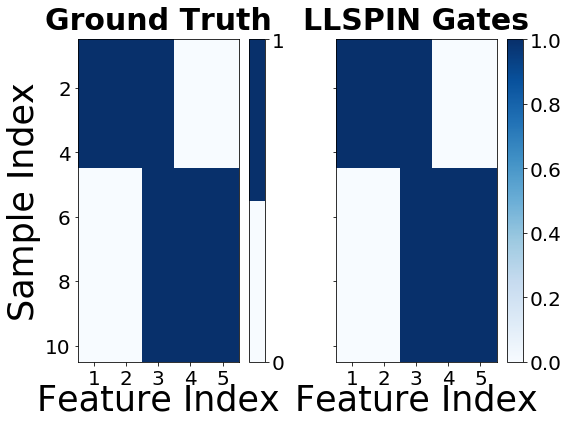

In [23]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(8, 6))

sorted_order = np.concatenate((np.where(train_label == 1)[0],np.where(train_label == 2)[0]))

im1 = axes[0].imshow(ref_feat_mat_train[sorted_order,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([1,3,5,7,9])
axes[0].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[0].set_xticks(list(range(5)))
axes[0].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

im2 = axes[1].imshow(gate_mat_train[sorted_order,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([1,3,5,7,9])
axes[1].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[1].set_xticks(list(range(5)))
axes[1].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()

### Comparing the test gates to the ground truth

In [24]:
gate_mat_test = best_model.get_prob_alpha(X_test)

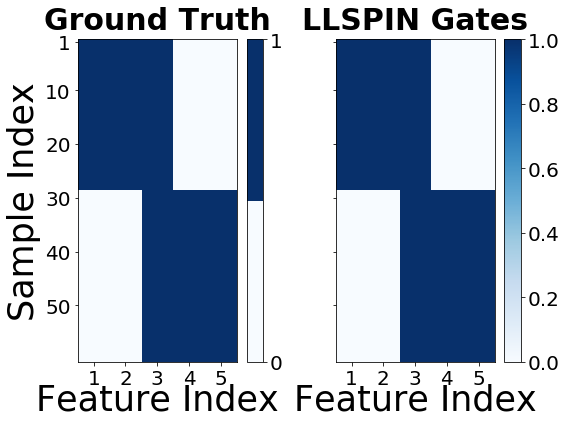

In [25]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(8, 6))

fig.subplots_adjust(bottom=0.01)

sorted_order_test = np.concatenate((np.where(test_label == 1)[0],np.where(test_label == 2)[0]))

im1 = axes[0].imshow(ref_feat_mat_test[sorted_order_test,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([0,9,19,29,39,49])
axes[0].set_yticklabels([1,10,20,30,40,50],fontsize=ytick_size)
axes[0].set_xticks(list(range(5)))
axes[0].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)
cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)
    
im2 = axes[1].imshow(gate_mat_test[sorted_order_test,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([0,9,19,29,39,49])
axes[1].set_yticklabels([1,10,20,30,40,50],fontsize=ytick_size)
axes[1].set_xticks(list(range(5)))
axes[1].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)
    
cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()